In [1]:
from utils.data_reader import SinD
from shapely.geometry import Point
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd

In [2]:
sind = SinD()

In [3]:
map = sind.map

In [36]:
COLOR_PALETE = ['#EF3D59', '#E17A47', '#4AB19D',  '#344E5C']

# Sidewalk Trajectories Analysis

### ALL TRAJECTORIES STARTING FROM THE SAME SIDEWALK

In [8]:
def plot_dataset(sind, pedestrian_data=None, color:str = "orange", map_overlay: bool = True, alpha: float = 0.2, title:int = 0):
    map = sind.map
    pedestrian_data = pedestrian_data if pedestrian_data else sind.pedestrian_data
    ax2 = map.plot_areas(alpha=alpha)[0] if map_overlay == True else plt.figure(2).add_subplot()
    for _id in pedestrian_data.keys():
        x, y = np.array(pedestrian_data[_id]["x"]), np.array(pedestrian_data[_id]["y"])
        ax2.plot(x, y, c=color), ax2.set_title(f"Pedestrian trajectories starting from {title}")
    plt.grid()
    plt.savefig(f"./{title}.png")

In [9]:
trajectories_per_sidewalk = {0: [], 1: [], 2: [], 3: []}
rest_trajectories = {'gap': [], 'road': [], 'inter': [], 'crosswalk': []}
for key, trajectory in sind.pedestrian_data.items():
    _trajectory_x, _trajectory_y = np.array(trajectory['x']), np.array(trajectory['y'])
    start_point = Point((_trajectory_x[0], _trajectory_y[0]))
    for i in range(0, 4):
        if start_point.within(map.sidewalk_poly[i]) or start_point.touches(map.sidewalk_poly[i]):
            trajectories_per_sidewalk[i].append(key)
    
    if not start_point.within(map.sidewalk_poly) and not start_point.touches(map.sidewalk_poly):
        if start_point.within(map.gap_poly) or start_point.touches(map.gap_poly):
            rest_trajectories['gap'].append(key)
        if start_point.within(map.road_poly) or start_point.touches(map.road_poly):
            rest_trajectories['road'].append(key)
        if start_point.within(map.intersection_poly) or start_point.touches(map.intersection_poly):
            rest_trajectories['inter'].append(key)
        if start_point.within(map.crosswalk_poly) or start_point.touches(map.crosswalk_poly):
            rest_trajectories['crosswalk'].append(key)

/tmp/ipykernel_139282/1594582206.py:7: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  if start_point.within(map.sidewalk_poly[i]) or start_point.touches(map.sidewalk_poly[i]):


/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages

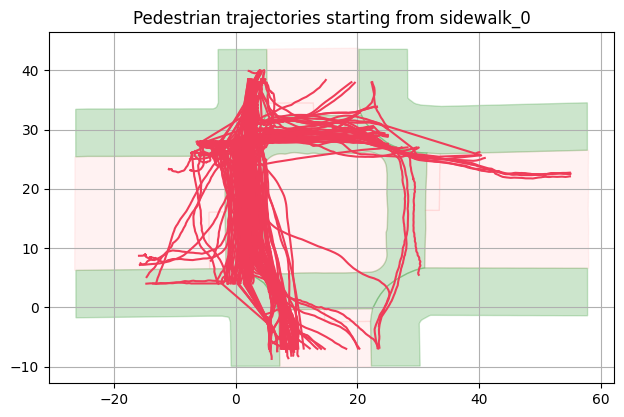

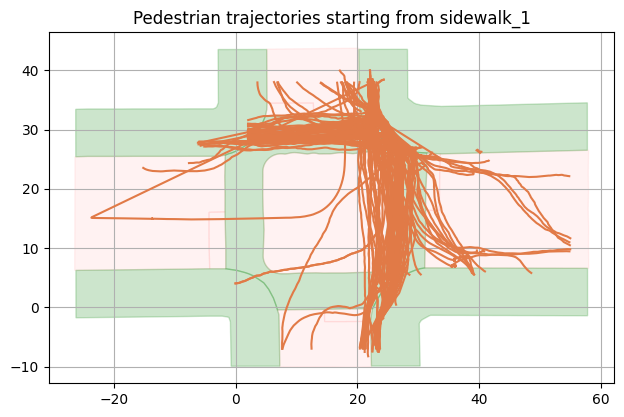

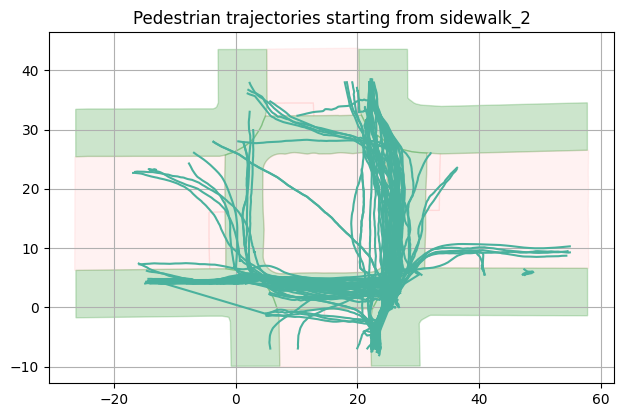

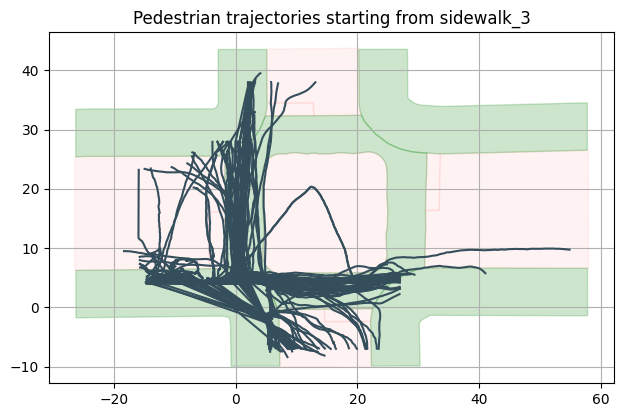

In [10]:

for sidewalk_id, pedestrian_ids in trajectories_per_sidewalk.items():
    # Gather pedestrian data for this sidewalk
    sidewalk_pedestrian_data = {pid: sind.pedestrian_data[pid] for pid in pedestrian_ids}

    # Plot the data for this sidewalk
    plot = plot_dataset(sind=sind, pedestrian_data=sidewalk_pedestrian_data, color=COLOR_PALETE[sidewalk_id], title=f'sidewalk_{sidewalk_id}')

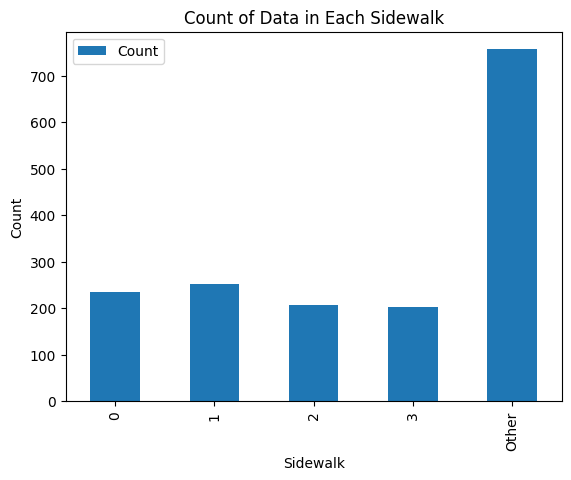

In [11]:
import matplotlib.pyplot as plt

# Create a bar plot
counts = {str(key): len(value) for key, value in trajectories_per_sidewalk.items()}
df = pd.DataFrame(list(counts.items()), columns=['Key', 'Count'])
df.loc[len(df.index)] = ['Other', len(sind.pedestrian_data) - df['Count'].sum()]

df.set_index('Key').plot(kind='bar')

# Add labels and title (optional)
plt.xlabel('Sidewalk')
plt.ylabel('Count')
plt.title('Count of Data in Each Sidewalk')

# Show the plot
plt.show()

### FLIP IMAGES

In [12]:
images = []
for sid in range(0, 4):
    images.append(Image.open(f'sidewalk_{sid}.png'))


In [13]:
rotated_1 = images[1].rotate(90)   # Rotate by -45 degrees
rotated_2 = images[2].rotate(180)   # Rotate by -90 degrees
rotated_3 = images[3].rotate(-90)   # Rotate by 45 degrees (or -45 degrees counter-clockwise)

In [14]:
total_width = images[0].width + rotated_1.width + rotated_2.width + rotated_3.width
max_height = max(images[0].height, rotated_1.height, rotated_2.height, rotated_3.height)

total_height  = images[0].height + rotated_1.height + rotated_2.height + rotated_3.height
max_width  = max(images[0].width, rotated_1.width, rotated_2.width, rotated_3.width)

merged_image = Image.new('RGB', (total_width, max_height))

In [15]:
x_offset = 0
for im in [images[0], rotated_1, rotated_2, rotated_3]:
    merged_image.paste(im, (x_offset, 0))
    x_offset += im.width

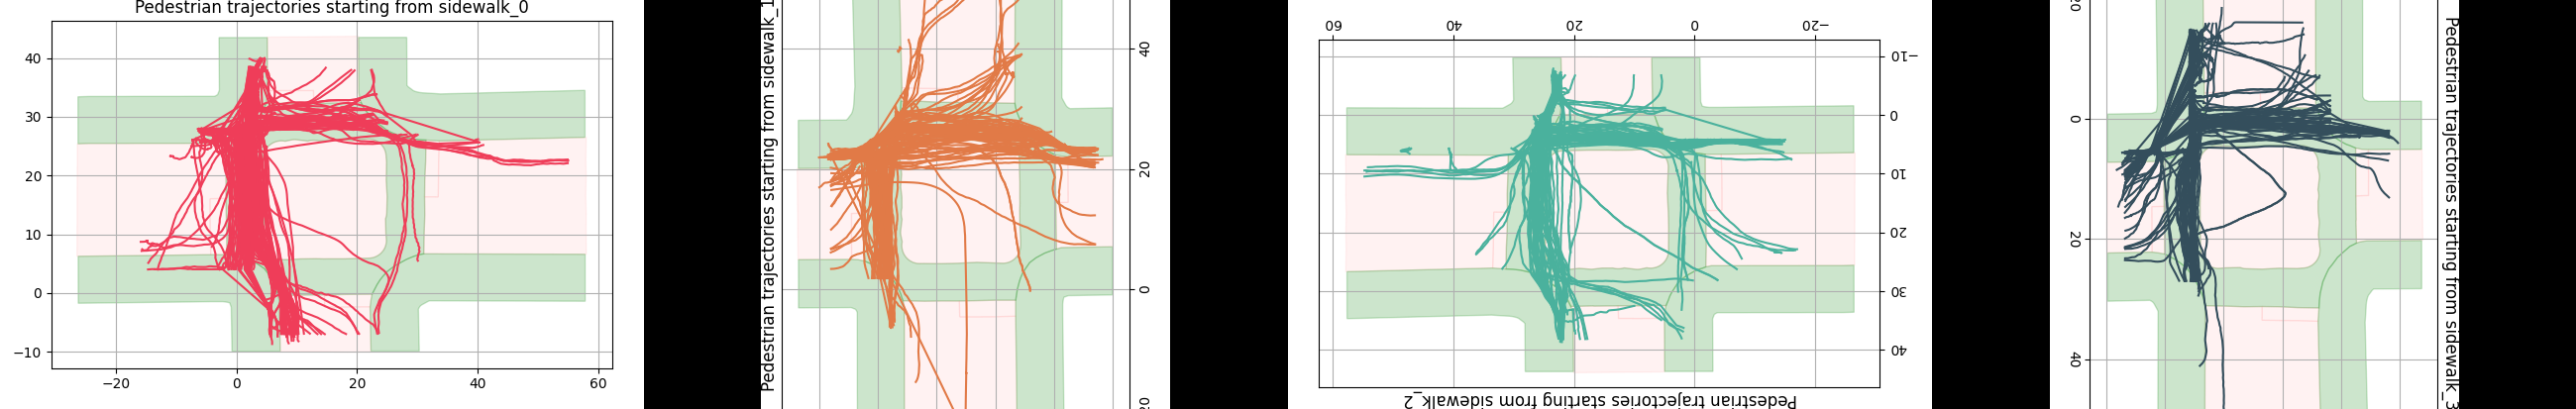

In [16]:
merged_image.show()  # To display the merged image


### Heatmaps

In [17]:
num_sidewalks = len(trajectories_per_sidewalk)

In [18]:
# Function to plot density heatmap
def plot_density_heatmap(ax, x_coords, y_coords, title, vmin, vmax):
    heatmap, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=100)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    cax = ax.imshow(heatmap.T, extent=extent, origin='lower', vmin=vmin, vmax=vmax, cmap='coolwarm')
    ax.set_title(title)
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')

    return cax


In [19]:
global_min = min([np.min(sind.pedestrian_data[pid]['y']) for pid in trajectories_per_sidewalk])
global_max = max([np.max(sind.pedestrian_data[pid]['y']) for pid in trajectories_per_sidewalk])

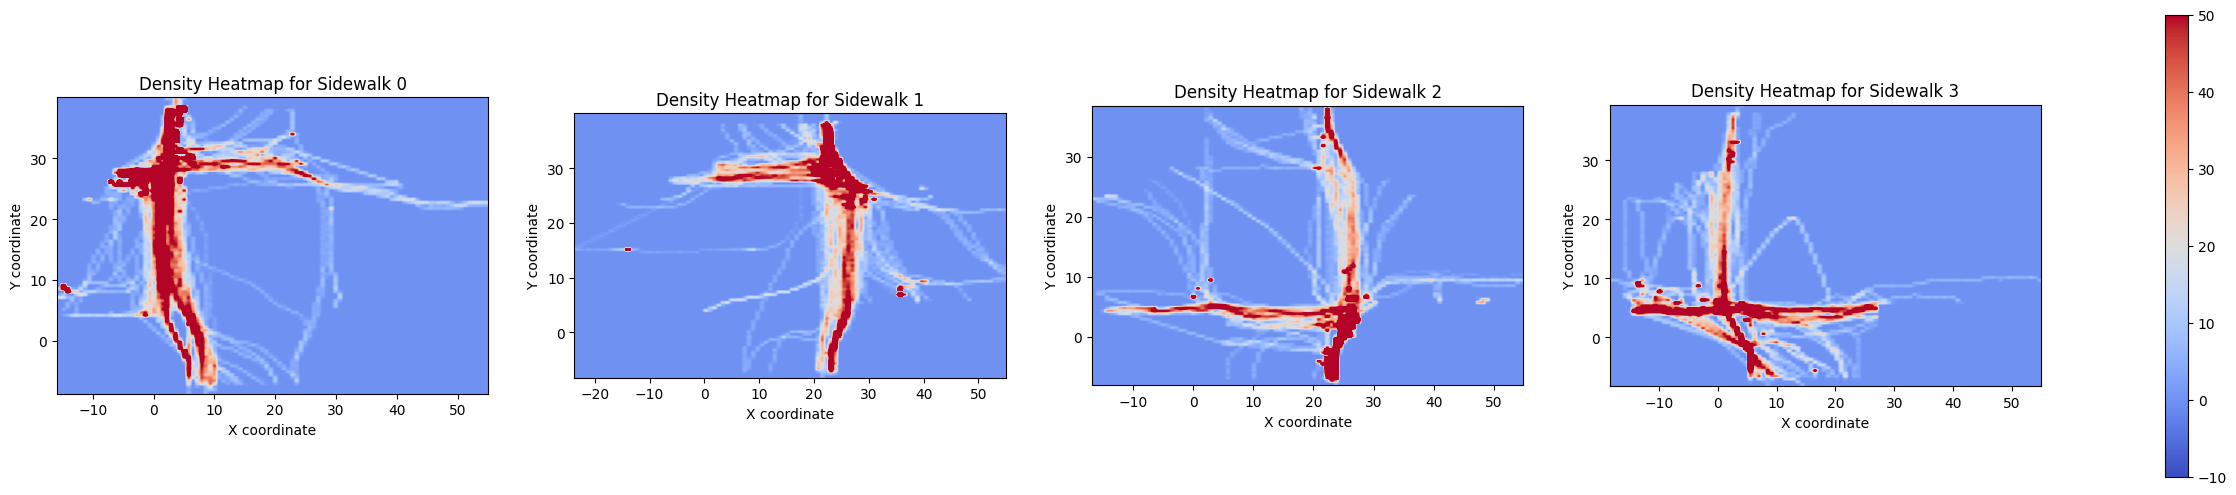

In [20]:
# Create a figure with subplots
num_rows = 1
num_cols = num_sidewalks
fig, axs = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 6 * num_rows))

# Process data for each sidewalk
for sidewalk_id, pedestrian_ids in trajectories_per_sidewalk.items():
    x_coords, y_coords = [], []
    for pid in pedestrian_ids:
        pedestrian_data = sind.pedestrian_data.get(pid, {})
        x_coords.extend(pedestrian_data.get('x', []))
        y_coords.extend(pedestrian_data.get('y', []))
    
    ax = axs.flat[sidewalk_id]
    # Plot density heatmap for the sidewalk
    cax = plot_density_heatmap(ax, x_coords, y_coords, f'Density Heatmap for Sidewalk {sidewalk_id}', -10, 50)
    # fig.colorbar(cax, ax=ax, orientation='vertical')

fig.colorbar(cax, ax=axs.ravel().tolist(), orientation='vertical')
plt.show()

### Plot rest of the data Trajectories

In [21]:
len(rest_trajectories)

4

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages

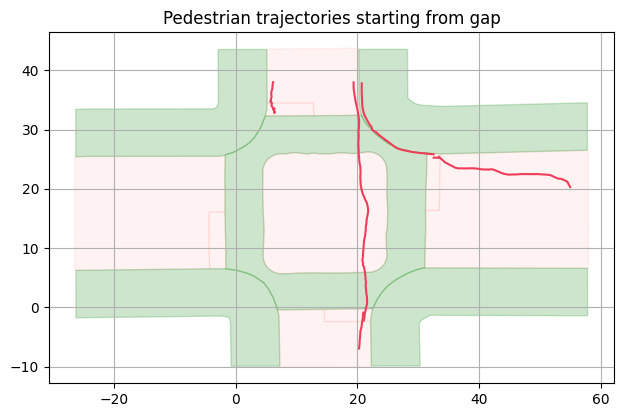

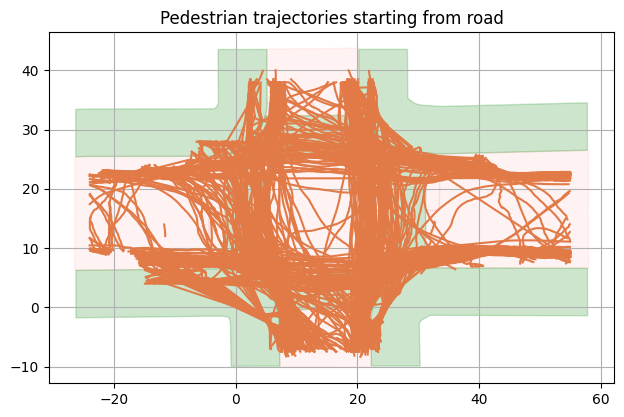

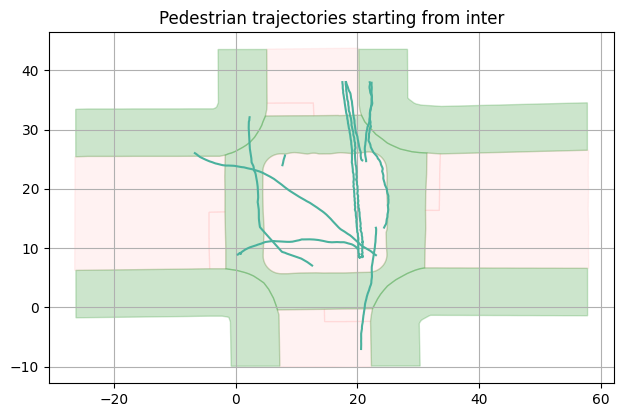

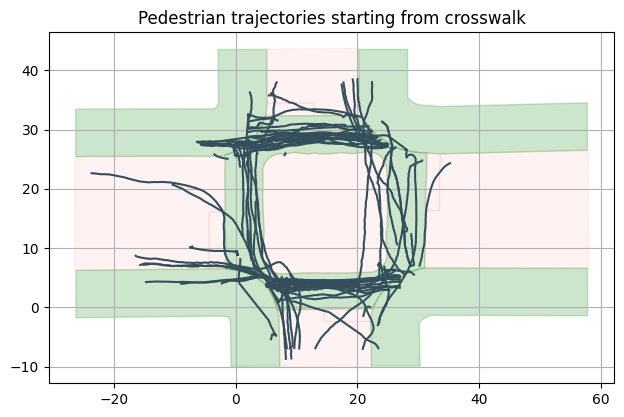

In [22]:
for idx, (key, pedestrian_ids) in enumerate(rest_trajectories.items()):
    # Gather pedestrian data for this sidewalk
    sidewalk_pedestrian_data = {pid: sind.pedestrian_data[pid] for pid in pedestrian_ids}

    # Plot the data for this sidewalk
    plot = plot_dataset(sind=sind, pedestrian_data=sidewalk_pedestrian_data, color=COLOR_PALETE[idx], title=key)

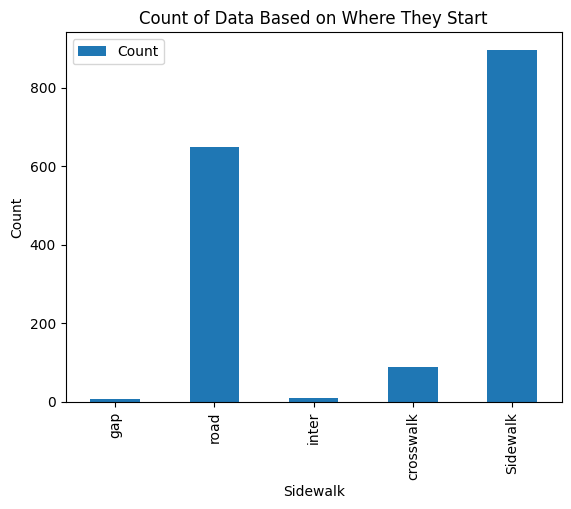

In [23]:
import matplotlib.pyplot as plt

# Create a bar plot
counts = {str(key): len(value) for key, value in rest_trajectories.items()}
df = pd.DataFrame(list(counts.items()), columns=['Key', 'Count'])
df.loc[len(df.index)] = ['Sidewalk', len(sind.pedestrian_data) - df['Count'].sum()]

df.set_index('Key').plot(kind='bar')

# Add labels and title (optional)
plt.xlabel('Sidewalk')
plt.ylabel('Count')
plt.title('Count of Data Based on Where They Start')

# Show the plot
plt.show()

### One Example

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


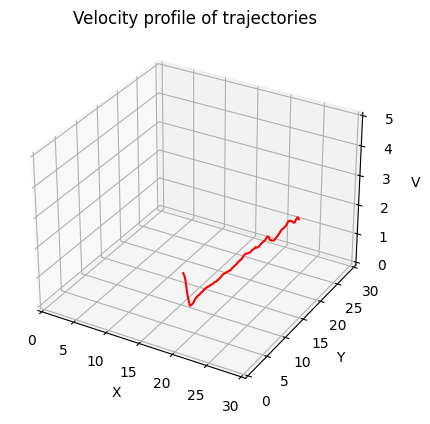

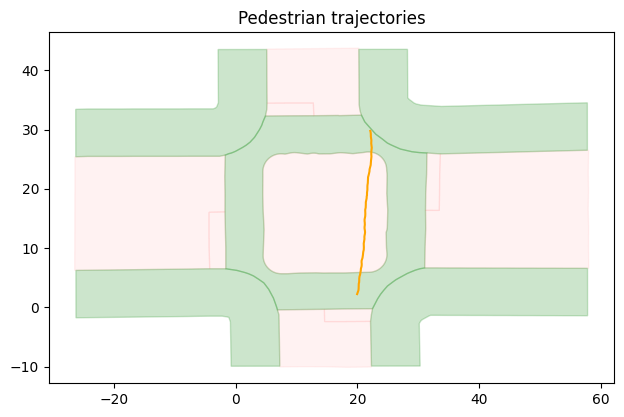

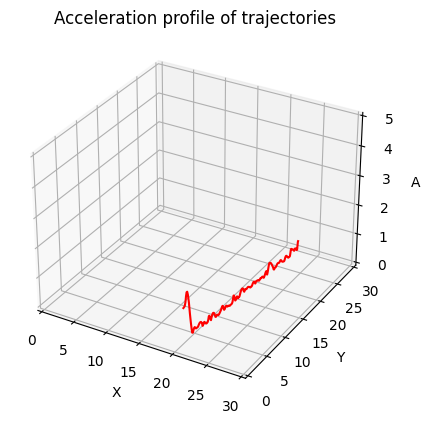

In [24]:
sind.plot_dataset(data={0: sind.pedestrian_data[0]})

# Clusters Brainstorming

In [39]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString

In [26]:
_features = []

for pid, data in sind.pedestrian_data.items():
    vx, vy, ax, ay = data['vx'], data['vy'], data['ax'], data['ay']
    speed = np.sqrt(np.square(vx) + np.square(vy))
    acceleration = np.sqrt(np.square(ax) + np.square(ay))
    
    # Example: Using mean speed and acceleration as features
    mean_speed = np.mean(speed)
    mean_acceleration = np.mean(acceleration)
    _features.append([mean_speed, mean_acceleration])

_features = np.array(_features)

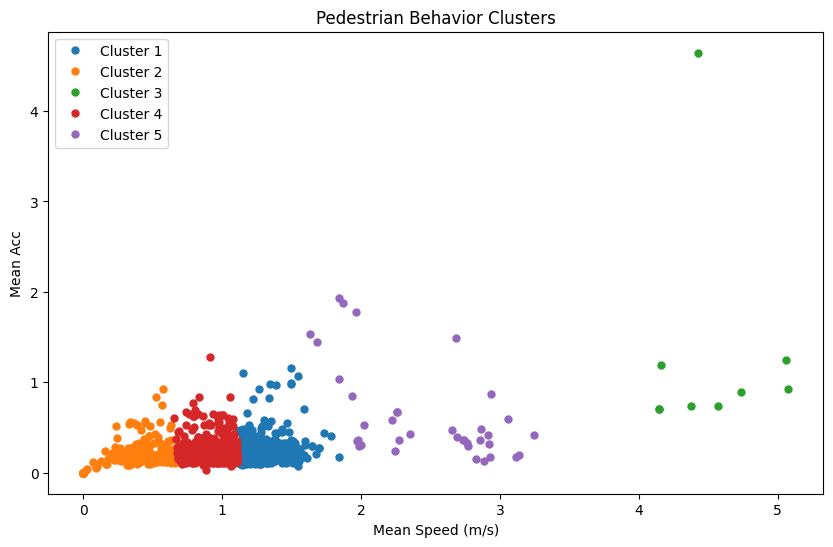

In [27]:
# Number of clusters
k = 5  # Adjust this based on your data

# Perform k-means clustering
kmeans = KMeans(n_clusters=k)
kmeans.fit(_features)
labels = kmeans.labels_
plt.figure(figsize=(10, 6))
for i in range(k):
    # Select only data points with label == i
    ds = _features[np.where(labels == i)]
    plt.plot(ds[:, 0].astype(float), ds[:, 1], 'o', markersize=5, label=f'Cluster {i+1}')

plt.xlabel('Mean Speed (m/s)')
plt.ylabel('Mean Acc')

plt.legend()
plt.title('Pedestrian Behavior Clusters')
plt.show()


In [28]:
label_encoder = LabelEncoder()

In [29]:
def check_char(point):
    char = ''
    for i in range(0, 4):
        if point.within(map.sidewalk_poly[i]) or point.touches(map.sidewalk_poly[i]):
            char = f'sidewalk{i}'

    if not point.within(map.sidewalk_poly) and not point.touches(map.sidewalk_poly):
        if point.within(map.gap_poly) or point.touches(map.gap_poly):
            char = f'gap'
        if point.within(map.road_poly) or point.touches(map.road_poly):
            char = f'road'
        if point.within(map.intersection_poly) or point.touches(map.intersection_poly):
            char = f'inter'
        if point.within(map.crosswalk_poly) or point.touches(map.crosswalk_poly):
            char = f'crosswalk'

    return char


In [30]:
def calculate_angle_between_vectors(v1, v2):
    unit_vector_1 = v1 / np.linalg.norm(v1)
    unit_vector_2 = v2 / np.linalg.norm(v2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    return angle

def calculate_direction_change(x, y):
    angles = []
    for i in range(2, len(x)):
        vec1 = [x[i-1] - x[i-2], y[i-1] - y[i-2]]
        vec2 = [x[i] - x[i-1], y[i] - y[i-1]]
        angle = calculate_angle_between_vectors(vec1, vec2)
        angles.append(angle)
    return np.nan_to_num(angles)  # Replace NaNs with 0

# Example: Calculating direction change for each pedestrian
features = []

for pid, data in sind.pedestrian_data.items():
    x, y = np.array(data['x']), np.array(data['y'])
    _trajectory_x, _trajectory_y = np.array(x), np.array(y)
    start_point = Point((_trajectory_x[0], _trajectory_y[0]))
    starting_point_char = check_char(start_point)
   
    direction_change = calculate_direction_change(x, y)
    mean_direction_change = np.mean(direction_change)
    features.append([mean_direction_change, starting_point_char])

features = np.array(features)
direction_changes = [float(feature[0]) for feature in features]
starting_points = [feature[1] for feature in features]
encoded_starting_points = label_encoder.fit_transform(starting_points)
combined_features = np.column_stack((direction_changes, encoded_starting_points))


/tmp/ipykernel_139282/3818831425.py:4: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  if point.within(map.sidewalk_poly[i]) or point.touches(map.sidewalk_poly[i]):
/tmp/ipykernel_139282/111860155.py:5: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(dot_product)
/tmp/ipykernel_139282/111860155.py:2: RuntimeWarning: invalid value encountered in divide
  unit_vector_1 = v1 / np.linalg.norm(v1)
/tmp/ipykernel_139282/111860155.py:3: RuntimeWarning: invalid value encountered in divide
  unit_vector_2 = v2 / np.linalg.norm(v2)


In [31]:
# Number of clusters
k = 3  # Adjust this based on your data

# Perform k-means clustering
kmeans = KMeans(n_clusters=k)
kmeans.fit(combined_features)
labels = kmeans.labels_


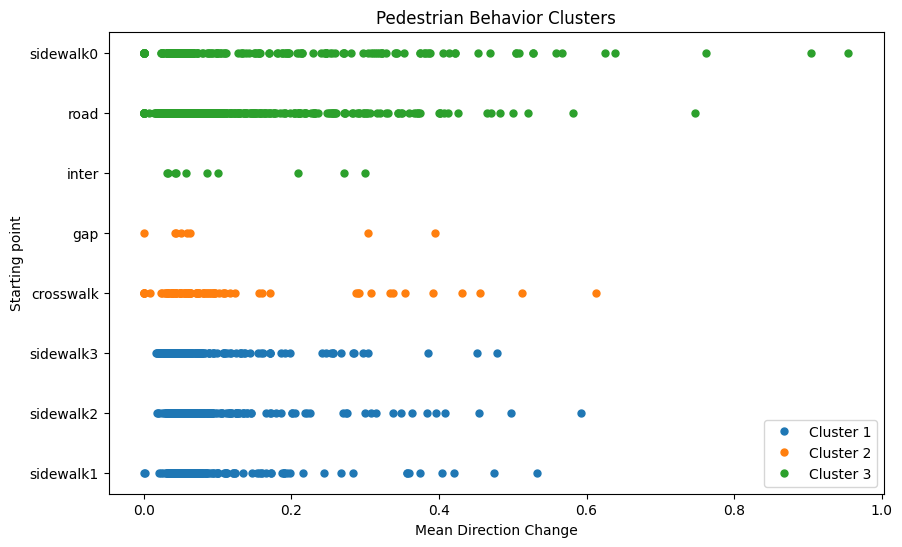

In [32]:
plt.figure(figsize=(10, 6))
for i in range(k):
    # Select only data points with label == i
    ds = features[np.where(labels == i)]
    plt.plot(ds[:, 0].astype(float), ds[:, 1], 'o', markersize=5, label=f'Cluster {i+1}')

plt.xlabel('Mean Direction Change')
plt.ylabel('Starting point')

plt.legend()
plt.title('Pedestrian Behavior Clusters')
plt.show()


### Check other ideas

In [33]:
def extract_features(data, map):
    features = []
    for pid, pdata in data.items():
        x, y = np.array(pdata['x']), np.array(pdata['y'])

        # Example feature calculations
        direction_change = calculate_direction_change(x, y)
        mean_direction_change = np.mean(direction_change)

        proximity_to_crosswalk = min([Point(x[i], y[i]).distance(map.crosswalk_poly) for i in range(len(x))])
        
        # Add more feature calculations as needed
        
        features.append([mean_direction_change, proximity_to_crosswalk])  # Add more features to this list
    return np.array(features)

# Extract features
features = extract_features(sind.pedestrian_data, map)


/tmp/ipykernel_139282/111860155.py:5: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(dot_product)
/tmp/ipykernel_139282/111860155.py:2: RuntimeWarning: invalid value encountered in divide
  unit_vector_1 = v1 / np.linalg.norm(v1)
/tmp/ipykernel_139282/111860155.py:3: RuntimeWarning: invalid value encountered in divide
  unit_vector_2 = v2 / np.linalg.norm(v2)


In [34]:
# Number of clusters
k = 6  # Adjust based on your analysis

# Perform k-means clustering
kmeans = KMeans(n_clusters=k)
kmeans.fit(features)
labels = kmeans.labels_

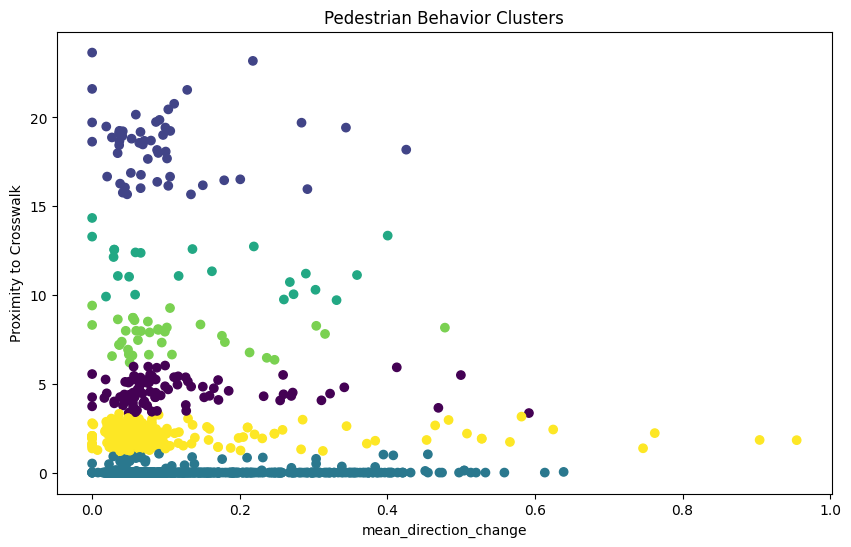

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
plt.xlabel('mean_direction_change')
plt.ylabel('Proximity to Crosswalk')
plt.title('Pedestrian Behavior Clusters')
plt.show()

##### Other 

In [36]:
def calculate_angle_between_vectors(v1, v2):
    """Calculate the angle between two vectors."""
    unit_vector_1 = v1 / np.linalg.norm(v1)
    unit_vector_2 = v2 / np.linalg.norm(v2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(np.clip(dot_product, -1.0, 1.0))  # Clip for floating point errors
    return np.degrees(angle)  # Convert to degrees

def calculate_turning_angles(path):
    """Calculate turning angles along a path."""
    angles = []
    for i in range(1, len(path.coords) - 1):
        p0 = np.array(path.coords[i - 1])
        p1 = np.array(path.coords[i])
        p2 = np.array(path.coords[i + 1])

        vec1 = p1 - p0
        vec2 = p2 - p1

        if np.linalg.norm(vec1) == 0 or np.linalg.norm(vec2) == 0:
            continue  # Skip if either vector is zero to avoid division by zero

        angle = calculate_angle_between_vectors(vec1, vec2)
        angles.append(angle)

    return angles

In [37]:
def is_crossing_street(pedestrian_path, map):
    return pedestrian_path.intersects(map.road_poly) or pedestrian_path.intersects(map.crosswalk_poly) \
        or pedestrian_path.intersects(map.intersection_poly) or pedestrian_path.intersects(map.gap_poly)

def is_illegal_crossing(pedestrian_path, map):
    return (pedestrian_path.intersects(map.road_poly) or pedestrian_path.intersects(map.intersection_poly)) \
        and not pedestrian_path.intersects(map.crosswalk_poly)

def has_made_turn(pedestrian_path, angle_threshold=30):
    # Assuming pedestrian_path is a LineString
    # Calculate the turning angles along the path
    angles = calculate_turning_angles(pedestrian_path)
    return any(angle > angle_threshold for angle in angles)
    # direction_change = calculate_direction_change(x, y)
    # mean_direction_change = np.mean(direction_change)
    # return mean_direction_change

# Example: Processing each pedestrian
features = []

for pid, data in sind.pedestrian_data.items():
    x, y = np.array(data['x']), np.array(data['y'])
    pedestrian_path = LineString(zip(x, y))
    
    crossing_feature = is_crossing_street(pedestrian_path, map)
    illegal_crossing_feature = is_illegal_crossing(pedestrian_path, map)
    turn_feature = has_made_turn(pedestrian_path)

    features.append([crossing_feature, illegal_crossing_feature, turn_feature])

# Convert features to NumPy array for clustering
features = np.array(features)


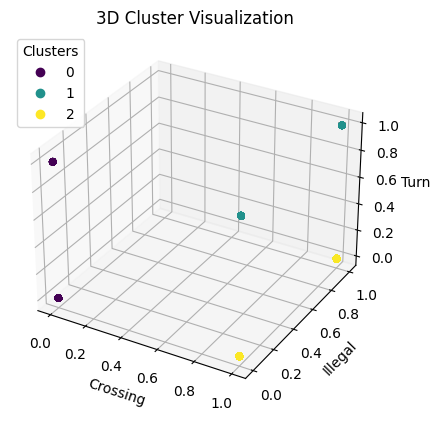

In [38]:
# Sample data - replace these with your actual features
feature1 = np.array([f[0] for f in features])  # E.g., Crossing
feature2 = np.array([f[1] for f in features])  # E.g., Illegal crossing flag
feature3 = np.array([f[2] for f in features])  # E.g., Turn

# Clustering (you might have already done this)
kmeans = KMeans(n_clusters=3)
kmeans.fit(features)
labels = kmeans.labels_

# Creating a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(feature1, feature2, feature3, c=labels, cmap='viridis')

# Labeling axes
ax.set_xlabel('Crossing')
ax.set_ylabel('Illegal')
ax.set_zlabel('Turn')

# Legend and title
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.title('3D Cluster Visualization')

plt.show()


# Create Dataframe

In [80]:
sind = SinD()
map = sind.map

In [81]:
input_len = 90

In [82]:
chunk_data = sind.data(input_len=input_len)
pedestrian_data = sind.pedestrian_data

Retreiving input:   0%|          | 0/1654 [00:00<?, ?it/s]

Retreiving input: 100%|██████████| 1654/1654 [01:10<00:00, 23.40it/s]


##### Chunk Data

In [85]:
def calculate_angle_between_vectors(v1, v2):
    # TODO test thoroughly, recreate the 45 degrees angle
    unit_vector_1 = v1 / np.linalg.norm(v1)
    unit_vector_2 = v2 / np.linalg.norm(v2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    return angle

def calculate_turning_angles(path):
    """Calculate turning angles along a path."""
    angles = []
    for i in range(1, len(path.coords) - 1):
        p0 = np.array(path.coords[i - 1])
        p1 = np.array(path.coords[i])
        p2 = np.array(path.coords[i + 1])

        vec1 = p1 - p0
        vec2 = p2 - p1

        if np.linalg.norm(vec1) == 0 or np.linalg.norm(vec2) == 0:
            continue  # Skip if either vector is zero to avoid division by zero

        angle = calculate_angle_between_vectors(vec1, vec2)
        angles.append(angle)

    return angles

def calculate_direction_change(x, y):
    angles = []
    for i in range(2, len(x)):
        vec1 = [x[i-1] - x[i-2], y[i-1] - y[i-2]]
        vec2 = [x[i] - x[i-1], y[i] - y[i-1]]
        angle = calculate_angle_between_vectors(vec1, vec2)
        angles.append(angle)
    return np.nan_to_num(angles)  # Replace NaNs with 0

def is_crossing_street(pedestrian_path, map):
    return pedestrian_path.intersects(map.road_poly) or pedestrian_path.intersects(map.crosswalk_poly) \
        or pedestrian_path.intersects(map.intersection_poly) or pedestrian_path.intersects(map.gap_poly)

def is_illegal_crossing(pedestrian_path, map):
    return (pedestrian_path.intersects(map.road_poly) or pedestrian_path.intersects(map.intersection_poly))

def has_made_turn(pedestrian_path, angle_threshold=30):
    # Assuming pedestrian_path is a LineString
    # Calculate the turning angles along the path
    angles = calculate_turning_angles(pedestrian_path)
    return any(angle > angle_threshold for angle in angles)

def check_point_location(point):
    point_location = ''
    for i in range(0, 4):
        if point.within(map.sidewalk_poly[i]) or point.touches(map.sidewalk_poly[i]):
            point_location = f'sidewalk{i}'

    if not point.within(map.sidewalk_poly) and not point.touches(map.sidewalk_poly):
        if point.within(map.gap_poly) or point.touches(map.gap_poly):
            point_location = f'gap'
        if point.within(map.road_poly) or point.touches(map.road_poly):
            point_location = f'road'
        if point.within(map.intersection_poly) or point.touches(map.intersection_poly):
            point_location = f'inter'
        if point.within(map.crosswalk_poly) or point.touches(map.crosswalk_poly):
            point_location = f'crosswalk'

    return point_location


In [86]:
df = pd.DataFrame()
for pedestrian_id in range(chunk_data.shape[0]):
    data = []
    idx = 0
    for j in range(6):
        data.append(pd.DataFrame(chunk_data).iloc[pedestrian_id,:][idx:idx+input_len])
        idx += input_len
    
    x, y, vx, vy, ax, ay = data[0].reset_index(drop=True), data[1].reset_index(drop=True), \
        data[2].reset_index(drop=True), data[3].reset_index(drop=True), data[4].reset_index(drop=True), data[5].reset_index(drop=True)

    speed = pd.DataFrame(np.sqrt(np.square(vx.to_numpy()) + np.square(vy.to_numpy())))
    acceleration = pd.DataFrame(np.sqrt(np.square(ax.to_numpy()) + np.square(ay.to_numpy())))
    direction_change = pd.DataFrame(calculate_direction_change(x, y))
    proximity_to_crosswalk = Point(x[0], y[0]).distance(map.crosswalk_poly)
    proximity_to_road_start = Point(x[0], y[0]).distance(map.road_poly)
    proximity_to_road_min = min([Point(x[i], y[i]).distance(map.road_poly) for i in range(len(x))])
    proximity_to_inter_start = Point(x[0], y[0]).distance(map.intersection_poly)
    proximity_to_inter_min = min([Point(x[i], y[i]).distance(map.intersection_poly) for i in range(len(x))])

    pedestrian_path = LineString(zip(np.array(x), np.array(y))) 
    crossing_feature = is_crossing_street(pedestrian_path, map)
    illegal_crossing_feature = is_illegal_crossing(pedestrian_path, map)
    turn_feature = has_made_turn(pedestrian_path)

    # acceleration
    new_row_data = {}
    new_row_data['acc__min'] = acceleration.min()[0]
    new_row_data['acc__max'] = acceleration.max()[0]
    new_row_data['acc__avg'] = acceleration.mean()[0]
    new_row_data['acc__median'] = acceleration.quantile(.5)[0]
    new_row_data['acc__first_quantile'] = acceleration.quantile(.25)[0]
    new_row_data['acc__last_quantile'] = acceleration.quantile(.75)[0]

    # speed
    new_row_data['speed__min'] = speed.min()[0]
    new_row_data['speed__max'] = speed.max()[0]
    new_row_data['speed__avg'] = speed.mean()[0]
    new_row_data['speed__median'] = speed.quantile(.5)[0]
    new_row_data['speed__first_quantile'] = speed.quantile(.25)[0]
    new_row_data['speed__last_quantile'] = speed.quantile(.75)[0]

    # direction change
    new_row_data['direction_change__min'] = direction_change.min()[0]
    new_row_data['direction_change__max'] = direction_change.max()[0]
    new_row_data['direction_change__avg'] = direction_change.mean()[0]
    new_row_data['direction_change__median'] = direction_change.quantile(.5)[0]
    new_row_data['direction_change__first_quantile'] = direction_change.quantile(.25)[0]
    new_row_data['direction_change__last_quantile'] = speed.quantile(.75)[0]

    # proximity_to_crosswalk
    new_row_data['proximity_to_crosswalk__start'] = proximity_to_crosswalk

    # proximity_to_road
    new_row_data['proximity_to_road__start'] = proximity_to_road_start
    new_row_data['proximity_to_road__min'] = proximity_to_road_min

    # proximity_to_intersection
    new_row_data['proximity_to_inter__start'] = proximity_to_inter_start
    new_row_data['proximity_to_inter__min'] = proximity_to_inter_min

    # Action Features 
    # TODO add last point
    new_row_data['crossing'] = crossing_feature
    new_row_data['illegal_crossing'] = illegal_crossing_feature
    new_row_data['turning'] = turn_feature

    # Starting Point Feature
    # TODO add the count of points in each location type, 0 if not in a location type
    new_row_data['starting_point'] = check_point_location(Point(x[0], y[0]))

    new_row_df = pd.DataFrame([new_row_data])
    df = pd.concat([df, new_row_df], ignore_index=True)
    if pedestrian_id == 2: break

/tmp/ipykernel_199158/3467513148.py:52: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  if point.within(map.sidewalk_poly[i]) or point.touches(map.sidewalk_poly[i]):
/tmp/ipykernel_199158/3467513148.py:52: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  if point.within(map.sidewalk_poly[i]) or point.touches(map.sidewalk_poly[i]):
/tmp/ipykernel_199158/3467513148.py:52: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  if point.within(map.sidewalk_poly[i]) or point.touches(map.sidewalk_poly[i]):


In [87]:
pd.set_option('display.max_columns', None)
df

acc__min  acc__max  acc__avg  acc__median  acc__first_quantile  \
0  0.021629  1.581903  0.278795     0.127159             0.069928   
1  0.021629  1.581903  0.269563     0.127159             0.069928   
2  0.021629  1.581903  0.259745     0.127159             0.069928   

   acc__last_quantile  speed__min  speed__max  speed__avg  speed__median  \
0            0.221369    1.022547    2.254853    1.266251       1.251093   
1            0.221369    1.022547    2.141047    1.255219       1.251093   
2            0.221369    1.022547    2.009943    1.245440       1.251093   

   speed__first_quantile  speed__last_quantile  direction_change__min  \
0               1.214147              1.278794               0.000968   
1               1.214147              1.277818               0.000968   
2               1.214147              1.274860               0.000968   

   direction_change__max  direction_change__avg  direction_change__median  \
0               0.196695               0.069063                  0.058032   
1               0.196695               0.068369                  0.056793   
2               0.196695               0.068935                  0.058032   

   direction_change__first_quantile  direction_change__last_quantile  \
0                          0.036360                         1.278794   
1                          0.035867                         1.277818   
2                          0.036360                         1.274860   

   proximity_to_crosswalk__last_quantile  proximity_to_road__start  \
0                                    0.0                  4.617916   
1                                    0.0                  4.816207   
2                                    0.0                  4.950979   

   proximity_to_road__min  proximity_to_inter__start  proximity_to_inter__min  \
0                4.617916                   3.634793                      0.0   
1                4.816207                   3.438126                      0.0   
2                4.950979                   3.303840                      0.0   

   crossing  illegal_crossing  turning starting_point  
0      True              True    False      crosswalk  
1      True              True    False      crosswalk  
2      True              True    False      crosswalk

In [88]:
# df.to_csv('dataset_created_test.csv', encoding='utf-8', index=False)

##### Full Trajectories

In [409]:
# TODO Keep 90 e.g steps (experiment with that number) without overlaping and keep the last value as a feature of all the variables (e.g direction, speed, acc etc.) 
# ADD also heading

In [94]:
df_full = pd.DataFrame()
for pedestrian_id, dt in pedestrian_data.items():
    data = []
    idx = 0

    x, y, vx, vy, ax, ay = dt['x'].reset_index(drop=True), dt['y'].reset_index(drop=True), \
        dt['vx'].reset_index(drop=True), dt['vy'].reset_index(drop=True), dt['ax'].reset_index(drop=True), dt['ay'].reset_index(drop=True)

    speed = pd.DataFrame(np.sqrt(np.square(vx.to_numpy()) + np.square(vy.to_numpy())))
    acceleration = pd.DataFrame(np.sqrt(np.square(ax.to_numpy()) + np.square(ay.to_numpy())))
    direction_change = pd.DataFrame(calculate_direction_change(x, y))
    proximity_to_crosswalk = Point(x[0], y[0]).distance(map.crosswalk_poly)
    proximity_to_road_start = Point(x[0], y[0]).distance(map.road_poly)
    proximity_to_road_min = min([Point(x[i], y[i]).distance(map.road_poly) for i in range(len(x))])
    proximity_to_inter_start = Point(x[0], y[0]).distance(map.intersection_poly)
    proximity_to_inter_min = min([Point(x[i], y[i]).distance(map.intersection_poly) for i in range(len(x))])

    pedestrian_path = LineString(zip(np.array(x), np.array(y))) 
    crossing_feature = is_crossing_street(pedestrian_path, map)
    illegal_crossing_feature = is_illegal_crossing(pedestrian_path, map)
    turn_feature = has_made_turn(pedestrian_path)

    # acceleration
    new_row_data = {}
    new_row_data['acc__min'] = acceleration.min()[0]
    new_row_data['acc__max'] = acceleration.max()[0]
    new_row_data['acc__avg'] = acceleration.mean()[0]
    new_row_data['acc__median'] = acceleration.quantile(.5)[0]
    new_row_data['acc__first_quantile'] = acceleration.quantile(.25)[0]
    new_row_data['acc__last_quantile'] = acceleration.quantile(.75)[0]

    # speed
    new_row_data['speed__min'] = speed.min()[0]
    new_row_data['speed__max'] = speed.max()[0]
    new_row_data['speed__avg'] = speed.mean()[0]
    new_row_data['speed__median'] = speed.quantile(.5)[0]
    new_row_data['speed__first_quantile'] = speed.quantile(.25)[0]
    new_row_data['speed__last_quantile'] = speed.quantile(.75)[0]

    # direction change
    new_row_data['direction_change__min'] = direction_change.min()[0]
    new_row_data['direction_change__max'] = direction_change.max()[0]
    new_row_data['direction_change__avg'] = direction_change.mean()[0]
    new_row_data['direction_change__median'] = direction_change.quantile(.5)[0]
    new_row_data['direction_change__first_quantile'] = direction_change.quantile(.25)[0]
    new_row_data['direction_change__last_quantile'] = speed.quantile(.75)[0]

    # proximity_to_crosswalk
    new_row_data['proximity_to_crosswalk__start'] = proximity_to_crosswalk

    # proximity_to_road
    new_row_data['proximity_to_road__start'] = proximity_to_road_start
    new_row_data['proximity_to_road__min'] = proximity_to_road_min

    # proximity_to_intersection
    new_row_data['proximity_to_inter__start'] = proximity_to_inter_start
    new_row_data['proximity_to_inter__min'] = proximity_to_inter_min

    # Action Features
    new_row_data['crossing'] = crossing_feature
    new_row_data['illegal_crossing'] = illegal_crossing_feature
    new_row_data['turning'] = turn_feature

    # Starting Point Feature
    new_row_data['starting_point'] = check_point_location(Point(x[0], y[0]))

    new_row_df = pd.DataFrame([new_row_data])
    df_full = pd.concat([df_full, new_row_df], ignore_index=True)

/tmp/ipykernel_199158/3467513148.py:52: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  if point.within(map.sidewalk_poly[i]) or point.touches(map.sidewalk_poly[i]):
/tmp/ipykernel_199158/3467513148.py:52: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  if point.within(map.sidewalk_poly[i]) or point.touches(map.sidewalk_poly[i]):
/tmp/ipykernel_199158/3467513148.py:52: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  if point.within(map.sidewalk_poly[i]) or point.touches(map.sidewalk_poly[i]):
/tmp/ipykernel_199158/3467513148.py:52: Shapel

In [95]:
# df_full.to_csv('dataset_created__full_test.csv', encoding='utf-8', index=False)

In [98]:
df_full.shape, df.shape

((1654, 27), (3, 27))

# Analyze Dataset Created

In [201]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

In [202]:
COLOR_PALETE = ['#EF3D59', '#E17A47', '#EFC958', '#4AB19D',  '#344E5C', '#A6206A', '#568EA6', '#A2D4AB', '#5A5050']

In [203]:
data_full = pd.read_csv('dataset_created__full.csv')
data_full

acc__min  acc__max  acc__avg  acc__median  acc__first_quantile  \
0     1.244515e-02  1.581903  0.194399     0.121054             0.079720   
1     6.723472e-03  0.471089  0.143279     0.133704             0.067911   
2     5.373956e-03  0.596297  0.124349     0.097708             0.065055   
3     6.952918e-03  0.735693  0.157666     0.143343             0.090265   
4     3.014776e-02  2.276081  0.578023     0.153082             0.093362   
...            ...       ...       ...          ...                  ...   
1649  1.635426e-11  0.675163  0.139664     0.106264             0.034310   
1650  5.404349e-03  0.809366  0.154622     0.128069             0.083243   
1651  1.817354e-02  0.936924  0.322357     0.233017             0.183127   
1652  1.972908e-02  1.136005  0.294788     0.242207             0.150813   
1653  2.406332e-02  1.064018  0.408958     0.321984             0.174929   

      acc__last_quantile  speed__min  speed__max  speed__avg  speed__median  \
0               0.195477    1.022547    2.254853    1.260942       1.264751   
1               0.184536    1.091998    1.303416    1.204872       1.214066   
2               0.153471    0.016348    1.344773    0.716498       0.762654   
3               0.200075    0.525039    1.500763    0.947023       0.974237   
4               0.859758    1.156138    2.420682    1.301335       1.206275   
...                  ...         ...         ...         ...            ...   
1649            0.185980    0.022517    1.151113    0.576431       0.706959   
1650            0.180058    0.471191    1.206280    1.031651       1.052648   
1651            0.354599    0.949056    1.406011    1.278820       1.289643   
1652            0.382561    0.650831    1.830047    1.353005       1.454640   
1653            0.602679    0.044974    0.944463    0.470068       0.425946   

      ...  direction_change__last_quantile  proximity_to_crosswalk__start  \
0     ...                         1.299346                       0.000000   
1     ...                         1.231556                       1.839419   
2     ...                         0.801736                       5.259997   
3     ...                         1.013605                       6.714373   
4     ...                         1.233032                       1.569956   
...   ...                              ...                            ...   
1649  ...                         0.877518                       7.307007   
1650  ...                         1.091016                       4.333932   
1651  ...                         1.349058                       6.978259   
1652  ...                         1.531621                       6.884690   
1653  ...                         0.864779                       3.010188   

      proximity_to_road__start  proximity_to_road__min  \
0                     4.617916                3.027516   
1                     8.187568                0.000000   
2                     0.000000                0.000000   
3                     0.000000                0.000000   
4                     1.705273                1.527881   
...                        ...                     ...   
1649                  1.029587                0.880257   
1650                  2.503162                2.052959   
1651                  0.000000                0.000000   
1652                  0.000000                0.000000   
1653                  1.715741                1.216030   

      proximity_to_inter__start  proximity_to_inter__min  crossing  \
0                      3.634793                 0.000000      True   
1                      0.000000                 0.000000      True   
2                     11.405376                 0.000000      True   
3                     12.827377                 0.109312      True   
4                      6.310410                 6.310410     False   
...                         ...                      ...       ...   
1649                  13.470302     

In [204]:
data = pd.read_csv('dataset_created.csv')
data

acc__min  acc__max  acc__avg  acc__median  acc__first_quantile  \
0       0.021629  1.581903  0.278795     0.127159             0.069928   
1       0.021629  1.581903  0.269563     0.127159             0.069928   
2       0.021629  1.581903  0.259745     0.127159             0.069928   
3       0.021629  1.581903  0.247917     0.127159             0.069928   
4       0.021629  1.581903  0.233208     0.125207             0.069928   
...          ...       ...       ...          ...                  ...   
273597  0.031996  0.568242  0.216794     0.187623             0.127222   
273598  0.031996  0.568242  0.218172     0.188262             0.127222   
273599  0.031996  0.568242  0.220727     0.189839             0.127222   
273600  0.031996  0.568242  0.223951     0.191074             0.127222   
273601  0.031996  0.568242  0.227427     0.194902             0.127222   

        acc__last_quantile  speed__min  speed__max  speed__avg  speed__median  \
0                 0.221369    1.022547    2.254853    1.266251       1.251093   
1                 0.221369    1.022547    2.141047    1.255219       1.251093   
2                 0.221369    1.022547    2.009943    1.245440       1.251093   
3                 0.216930    1.022547    1.853691    1.237110       1.251093   
4                 0.209917    1.022547    1.684450    1.230487       1.251093   
...                    ...         ...         ...         ...            ...   
273597            0.277692    1.422717    1.671924    1.531739       1.530030   
273598            0.283645    1.422717    1.671924    1.531408       1.530030   
273599            0.288805    1.399847    1.671924    1.530458       1.530030   
273600            0.293230    1.346058    1.671924    1.528863       1.530030   
273601            0.295054    1.299799    1.671924    1.526750       1.530030   

        ...  direction_change__last_quantile  proximity_to_crosswalk__start  \
0       ...                         1.278794                            0.0   
1       ...                         1.277818                            0.0   
2       ...                         1.274860                            0.0   
3       ...                         1.271359                            0.0   
4       ...                         1.269321                            0.0   
...     ...                              ...                            ...   
273597  ...                         1.556152                            0.0   
273598  ...                         1.556152                            0.0   
273599  ...                         1.556152                            0.0   
273600  ...                         1.556152                            0.0   
273601  ...                         1.556152                            0.0   

        proximity_to_road__start  proximity_to_road__min  \
0                       4.617916                4.617916   
1                       4.816207                4.816207   
2                       4.950979                4.950979   
3                       5.047740                5.047740   
4                       5.132122                5.132122   
...                          ...                     ...   
273597                  6.252931                2.682002   
273598                  6.215382                2.682002   
273599                  6.172121                2.682002   
273600                  6.142086                2.682002   
273601                  6.115126                2.682002   

        proximity_to_inter__start  proximity_to_inter__min  crossing  \
0                        3.634793                 0.000000      True   
1                        3.438126                 0.000000      True   
2                        3.303840                 0.000000      True   
3                        3.207391                 0.000000      True   
4                        3.123469                 0.000000      True   
...                           ...           

### Check if other types of Pedestrians exist

##### Chunk Dataset

/tmp/ipykernel_13580/347361657.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data["speed__avg"], shade=True)


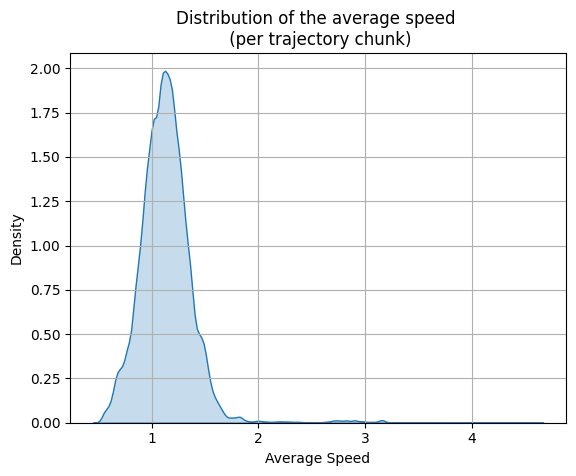

In [205]:
# plot the distribution of the avg speed per trajectory (misclassification of the bikes)
sns.kdeplot(data["speed__avg"], shade=True)
plt.title('Distribution of the average speed \n (per trajectory chunk)')
plt.xlabel('Average Speed')
plt.ylabel('Density')
plt.grid(True)  # This adds grid lines to the axes object
plt.show()

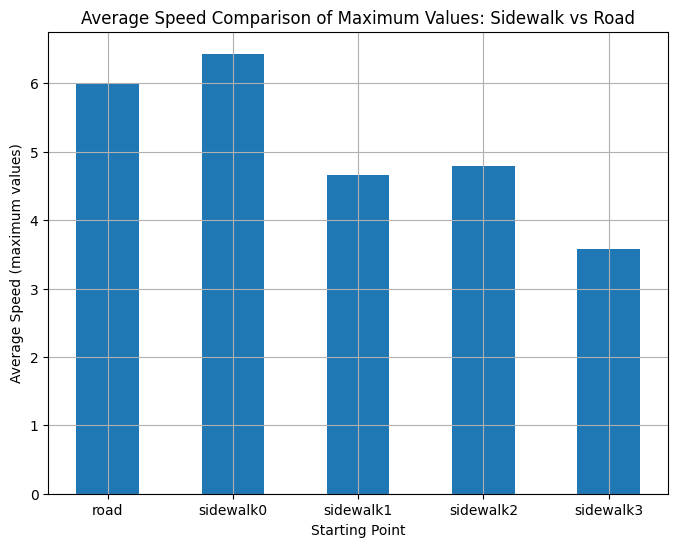

In [401]:
# compare the mean speed between the trajectories started from sidewalk vs road

filtered_data = data[data["starting_point"].isin(["sidewalk0", "sidewalk1", "sidewalk2", "sidewalk3", "road"])]

# # Calculate mean speeds for each starting point
mean_speeds = filtered_data.groupby('starting_point')['speed__max'].max()

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(mean_speeds.index, mean_speeds.values, width=.5)
plt.title('Average Speed Comparison of Maximum Values: Sidewalk vs Road')
plt.xlabel('Starting Point')
plt.ylabel('Average Speed (maximum values)')

plt.grid(True)  # This adds grid lines to the axes object
plt.show()

##### Dataset Full

/tmp/ipykernel_13580/3416949910.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_full["speed__avg"], shade=True)


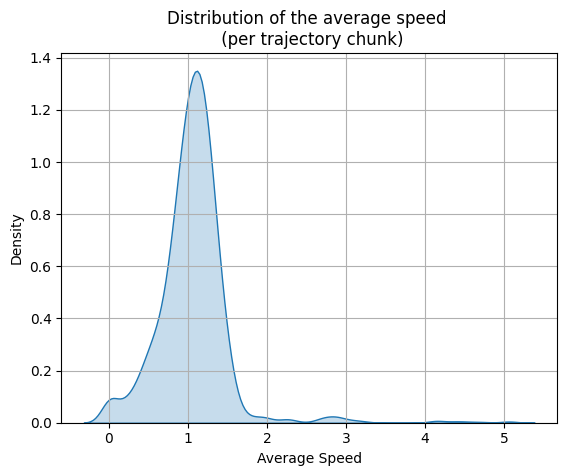

In [207]:
# plot the distribution of the avg speed per trajectory (misclassification of the bikes)
sns.kdeplot(data_full["speed__avg"], shade=True)
plt.title('Distribution of the average speed \n (per trajectory chunk)')
plt.xlabel('Average Speed')
plt.ylabel('Density')
plt.grid(True)  # This adds grid lines to the axes object
plt.show()

In [408]:
data_full["crossing"].sum() / data_full["crossing"].count() 

0.7974607013301088

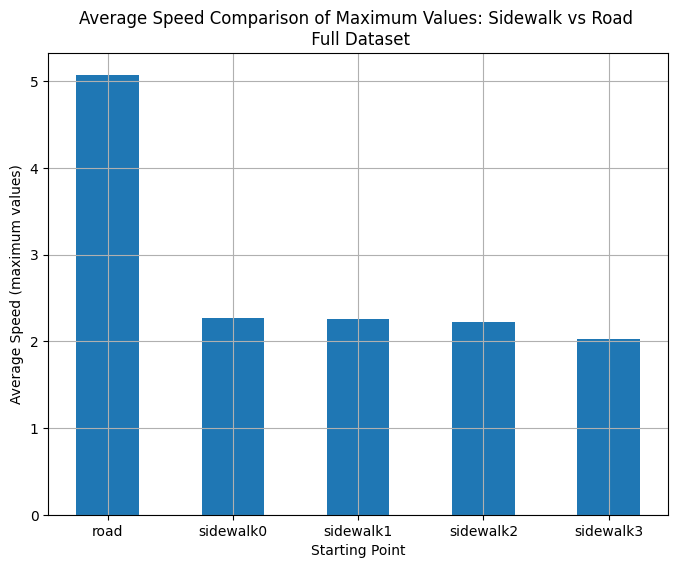

In [407]:
# compare the mean speed between the trajectories started from sidewalk vs road

filtered_data = data_full[data_full["starting_point"].isin(["sidewalk0", "sidewalk1", "sidewalk2", "sidewalk3", "road"])]

# # Calculate mean speeds for each starting point
mean_speeds = filtered_data.groupby('starting_point')['speed__avg'].max()

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(mean_speeds.index, mean_speeds.values, width=.5)
plt.title('Average Speed Comparison of Maximum Values: Sidewalk vs Road \n Full Dataset')
plt.xlabel('Starting Point')
plt.ylabel('Average Speed (maximum values)')

plt.grid(True)  # This adds grid lines to the axes object
plt.show()

In [400]:
# plot the trajectory speed distribution of those traj that have above avg 2.5

### PCA of the created Full Dataset

In [375]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [388]:
# Convert 'starting_point' to one-hot encoded format
one_hot = pd.get_dummies(data_full['starting_point'])

# Join the encoded df with the original df. You can also drop the original 'starting_point' column if it's no longer needed
df = data_full.join(one_hot).drop('starting_point', axis=1)

In [389]:
df.shape, data_full.shape, data.shape

((1654, 34), (1654, 27), (273602, 27))

In [390]:
# Standardizing the data is important because PCA is affected by the scale of the features.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [391]:
# Apply PCA

# Create a PCA instance: PCA for 2 components
pca = PCA(n_components=3)

# Fit and transform the data
principal_components = pca.fit_transform(df)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components)


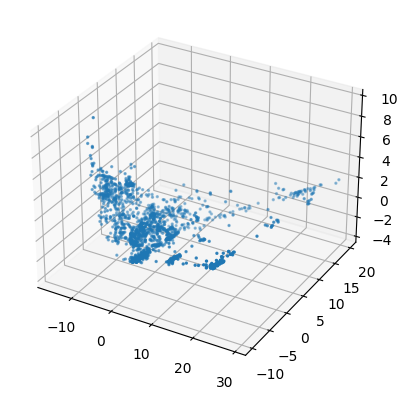

In [392]:
# Creating a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(pca_df[0], pca_df[1], pca_df[2], cmap='viridis', s=2)

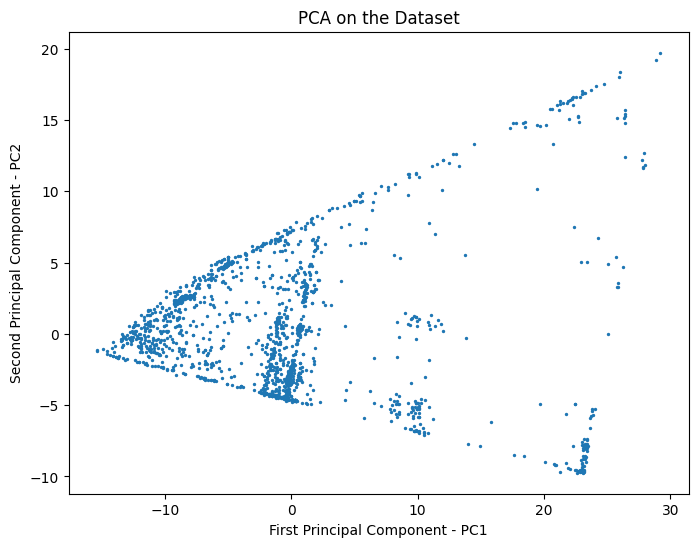

In [393]:
plt.figure(figsize=(8,6))
plt.scatter(pca_df[0], pca_df[1], s=2)
plt.xlabel('First Principal Component - PC1')
plt.ylabel('Second Principal Component - PC2')
plt.title('PCA on the Dataset')
plt.show()

### Feature Importance

### Clusters

In [346]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

In [360]:
pd.set_option('display.max_columns', None)

In [361]:
# Convert 'starting_point' to one-hot encoded format
one_hot = pd.get_dummies(data_full['starting_point'])

# Join the encoded df with the original df. You can also drop the original 'starting_point' column if it's no longer needed
df = data_full.join(one_hot).drop('starting_point', axis=1)

In [362]:
kmeans = KMeans(n_clusters=6)  # clusters
df['cluster'] = kmeans.fit_predict(df)

In [363]:
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns=df.columns[:-1])  # Assuming the last column is 'cluster'
cluster_sizes = df['cluster'].value_counts()
cluster_profiles = df.groupby('cluster').mean()

In [364]:
cluster_sizes

cluster
0    606
4    449
5    318
3    108
2     96
1     77
Name: count, dtype: int64

In [365]:
cluster_profiles

acc__min  acc__max  acc__avg  acc__median  acc__first_quantile  \
cluster                                                                   
0        0.008583  0.827696  0.194554     0.155065             0.087196   
1        0.158194  0.967972  0.458478     0.435826             0.286585   
2        0.006880  0.848767  0.168486     0.135897             0.075709   
3        0.006858  0.970897  0.173714     0.130065             0.067558   
4        0.024184  0.788964  0.217671     0.179125             0.108219   
5        0.066017  0.728999  0.300342     0.262643             0.159827   

         acc__last_quantile  speed__min  speed__max  speed__avg  \
cluster                                                           
0                  0.255546    0.627065    1.591744    1.135192   
1                  0.595556    0.739400    1.477463    1.070729   
2                  0.225606    0.782951    1.720844    1.231558   
3                  0.223791    0.639410    1.547640    1.135497   
4                  0.284851    0.593250    1.469905    1.017347   
5                  0.410874    0.600314    1.240879    0.880130   

         speed__median  speed__first_quantile  speed__last_quantile  \
cluster                                                               
0             1.174972               0.990728              1.293179   
1             1.078975               0.908200              1.220588   
2             1.239267               1.112620              1.355275   
3             1.161872               1.065445              1.233061   
4             1.031942               0.861485              1.176484   
5             0.869172               0.760761              0.988808   

         direction_change__min  direction_change__max  direction_change__avg  \
cluster                                                                        
0                     0.000210               1.021743               0.087813   
1                     0.003412               0.681993               0.105952   
2                     0.000057               0.848940               0.073443   
3                     0.000207               0.797381               0.066265   
4                     0.000854               1.030508               0.105376   
5                     0.002137               0.727366               0.113656   

         direction_change__median  direction_change__first_quantile  \
cluster                                                               
0                        0.044629                          0.017179   
1                        0.063420                          0.026465   
2                        0.037034                          0.014129   
3                        0.037257                          0.015861   
4                        0.052672                          0.021914   
5                        0.063393                          0.025085   

         direction_change__last_quantile  proximity_to_crosswalk__start  \
cluster                                                                   
0                               1.293179                       6.261249   
1                               1.220588                      19.052819   
2                               1.355275                      23.361879   
3                               1.233061                      13.602057   
4                               1.176484                       1.333208   
5                               0.988808                       5.152053   

         proximity_to_road__start  proximity_to_road__min  \
cluster                                                     
0                        0.862104                0.455469   
1                        0.056593                0.038120   
2                        0.000000                0.000000   
3                        0.677483                0.350602   
4                        4.253038                1.642606   
5                        1.075874                0.645482   

  

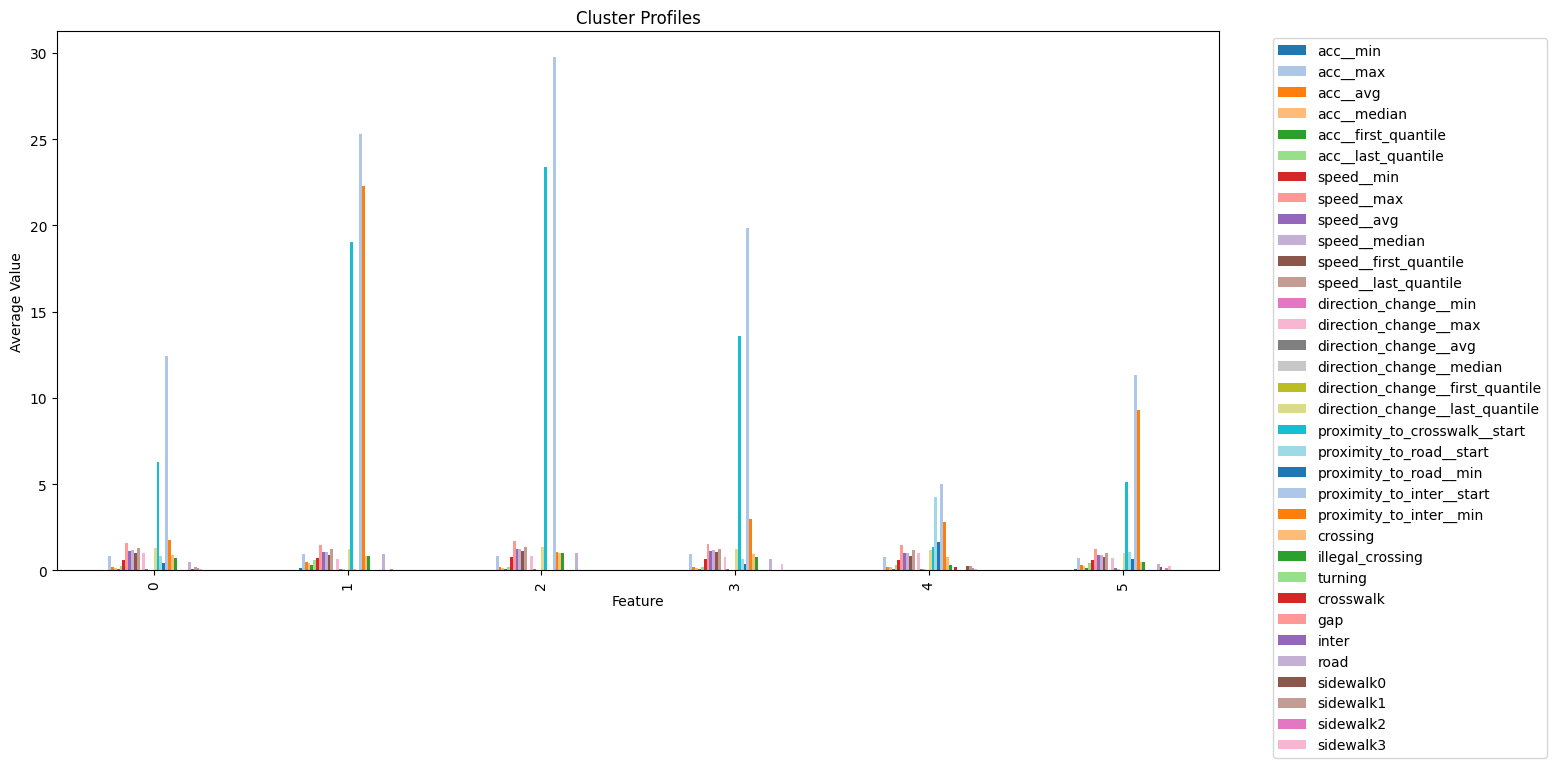

In [371]:
colormap = plt.cm.tab20.colors  # Tab20 colormap with 20 unique colors

cluster_profiles.plot(kind='bar', figsize=(15, 7), color=colormap)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title("Cluster Profiles")
plt.xlabel("Feature")
plt.ylabel("Average Value")
plt.show()

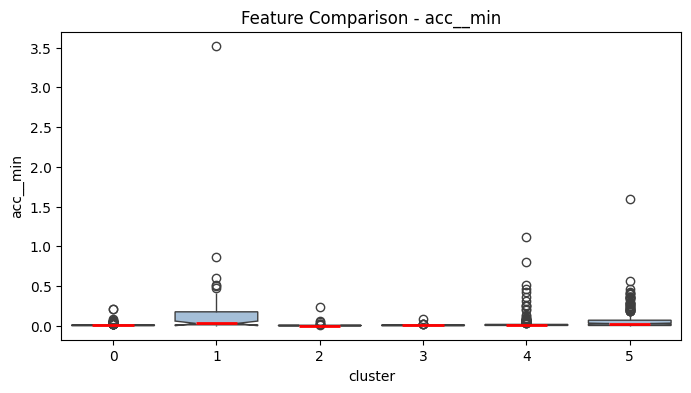

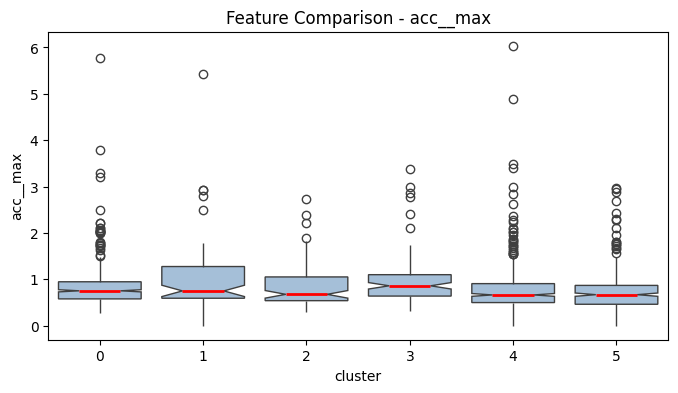

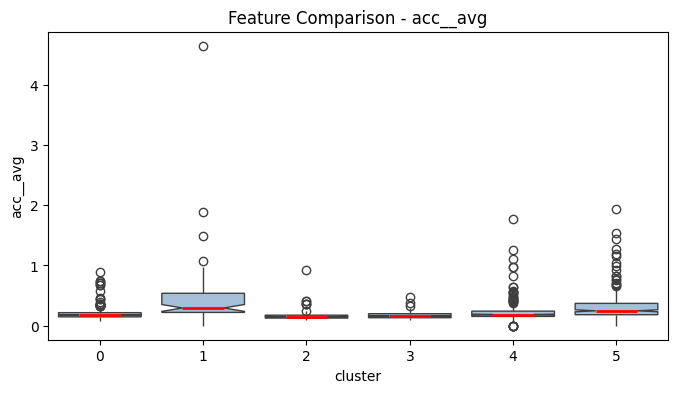

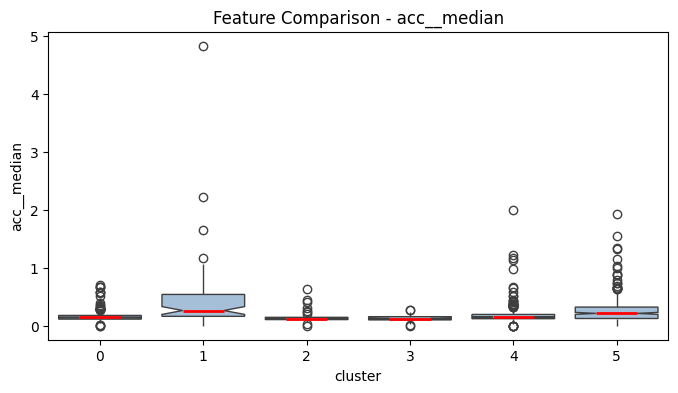

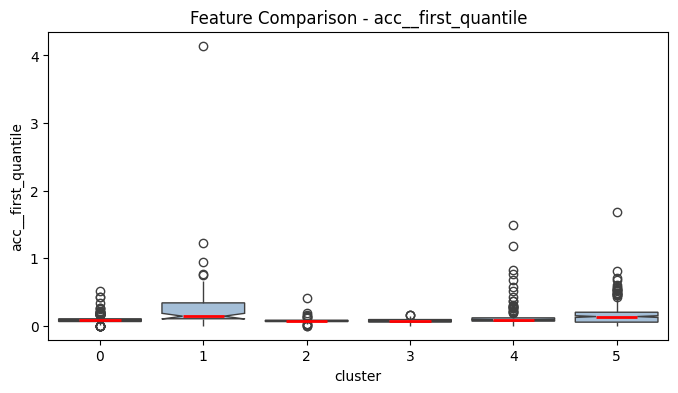

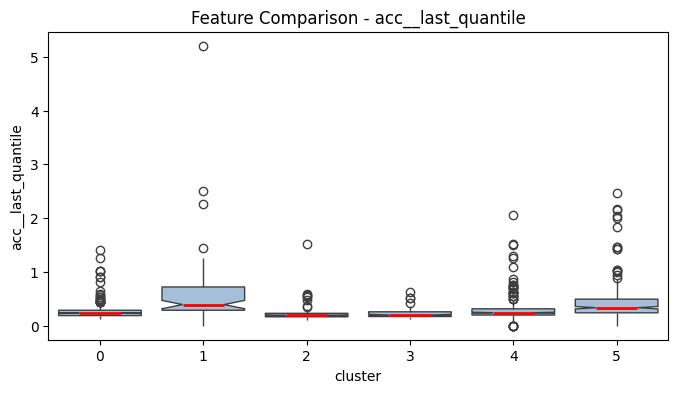

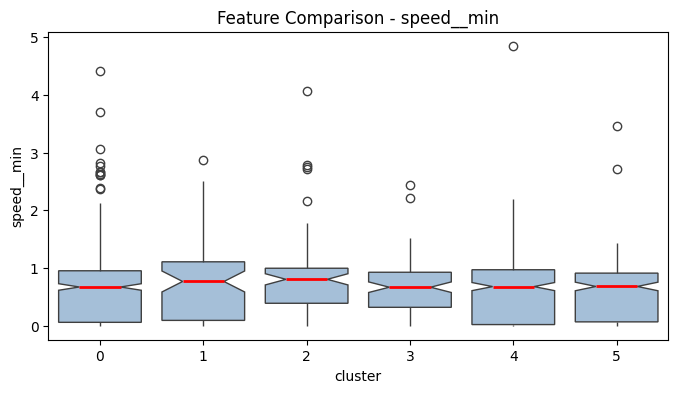

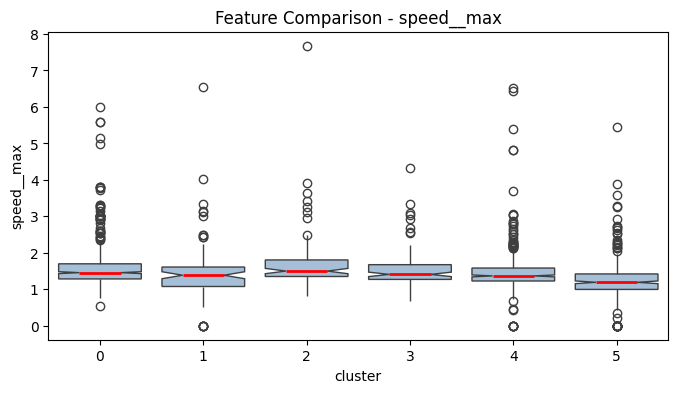

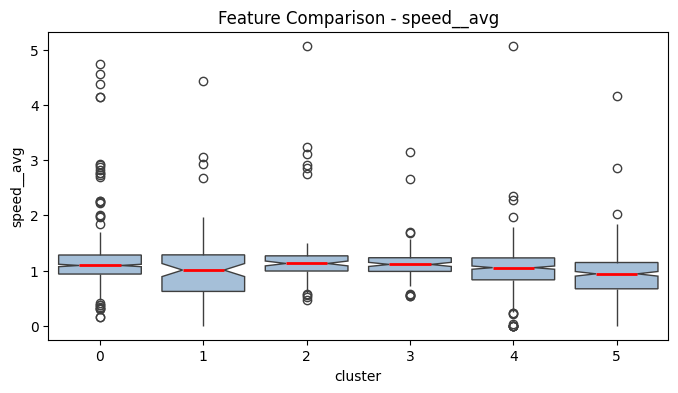

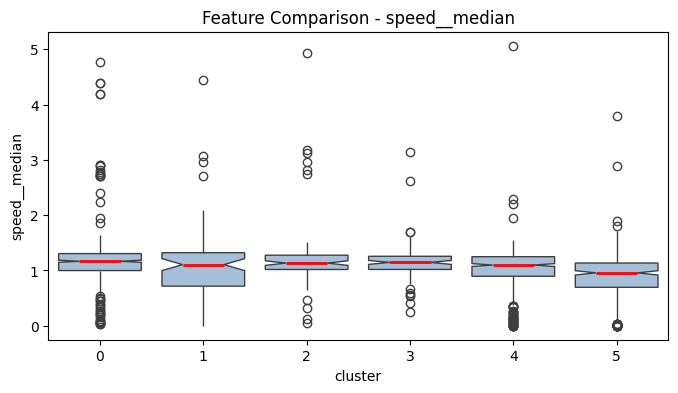

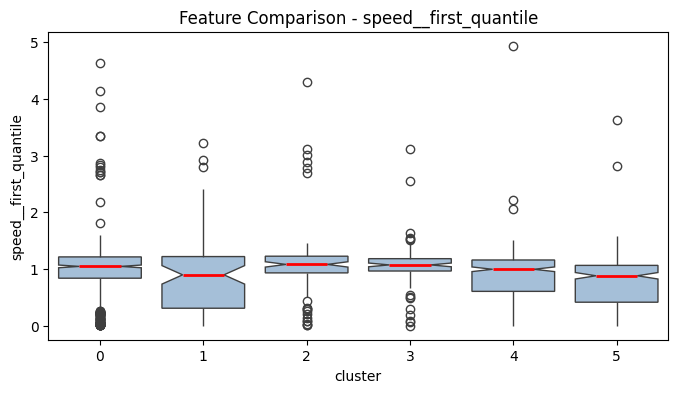

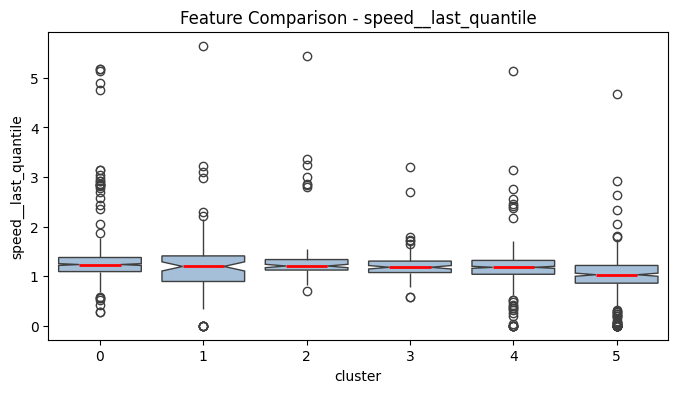

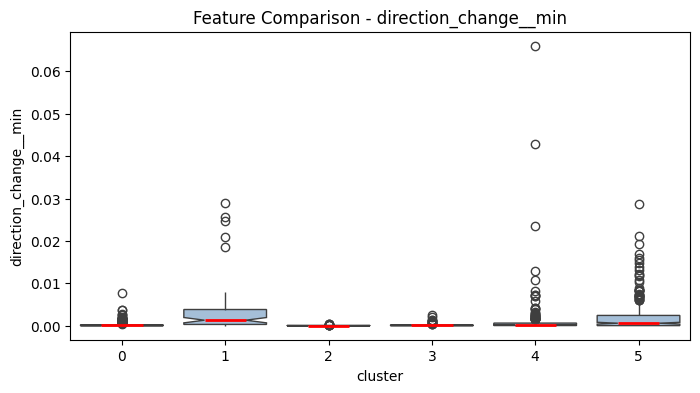

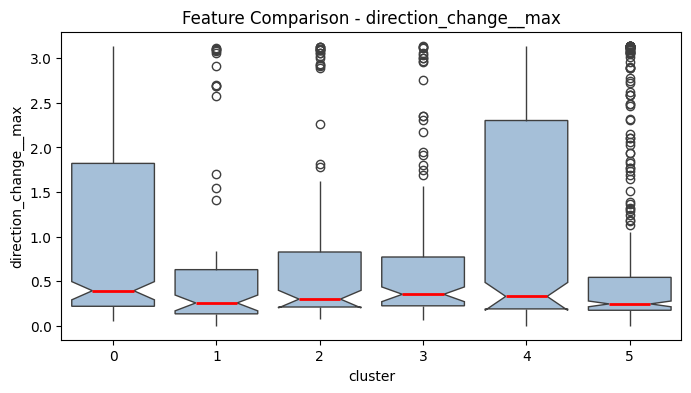

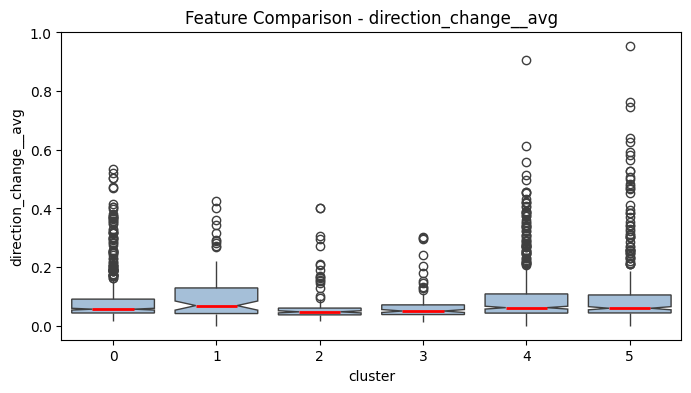

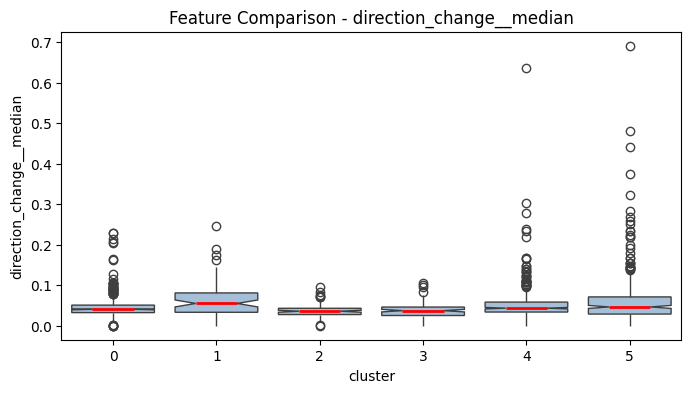

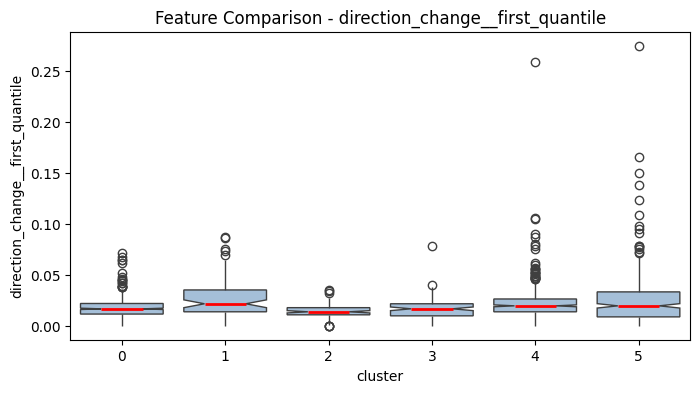

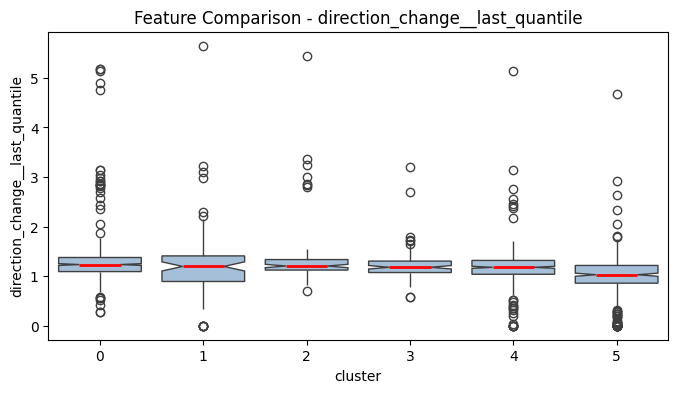

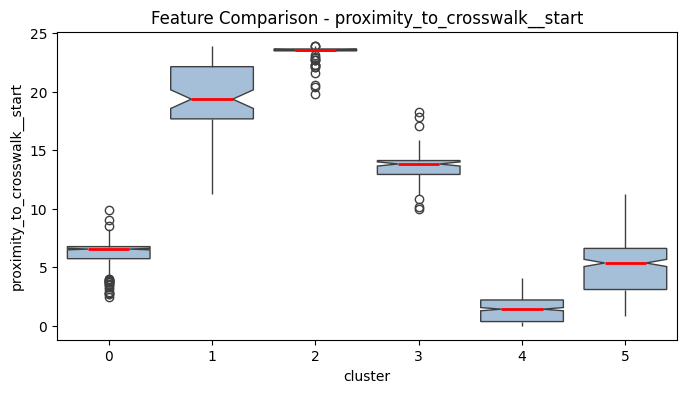

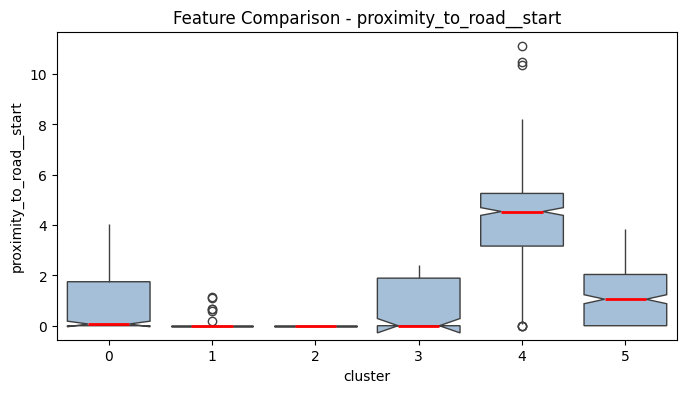

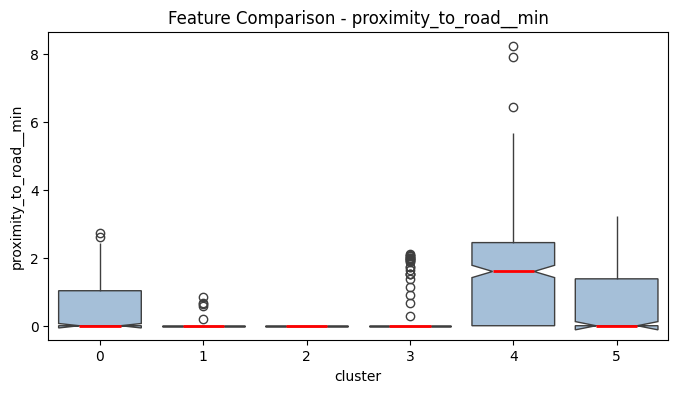

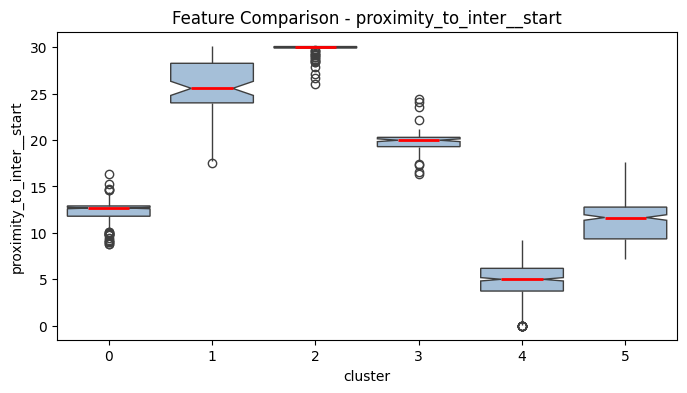

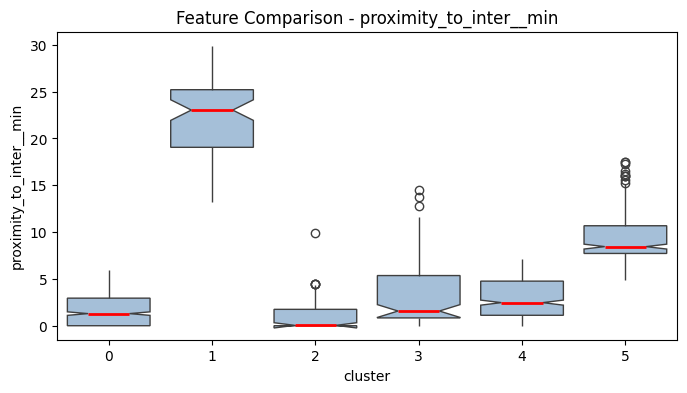

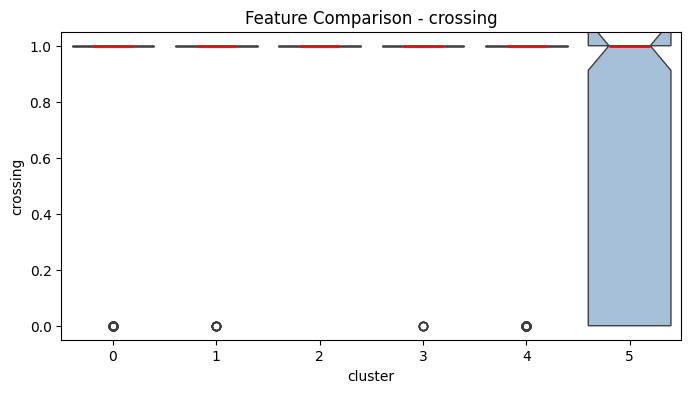

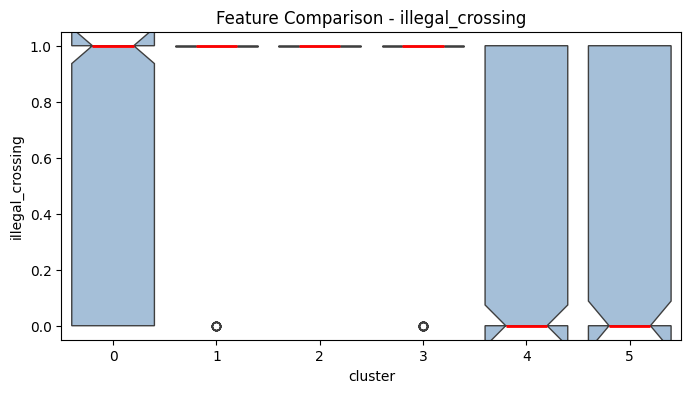

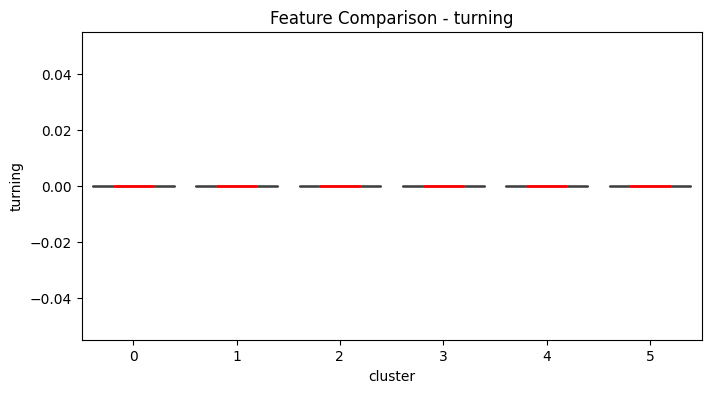

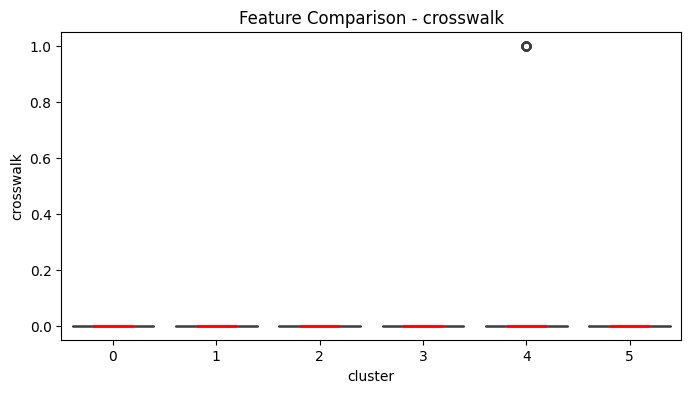

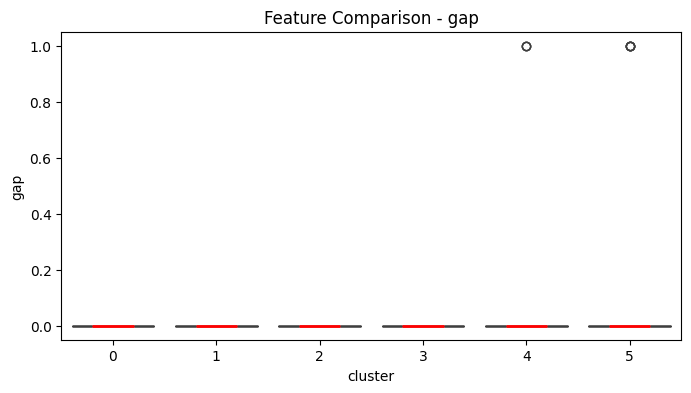

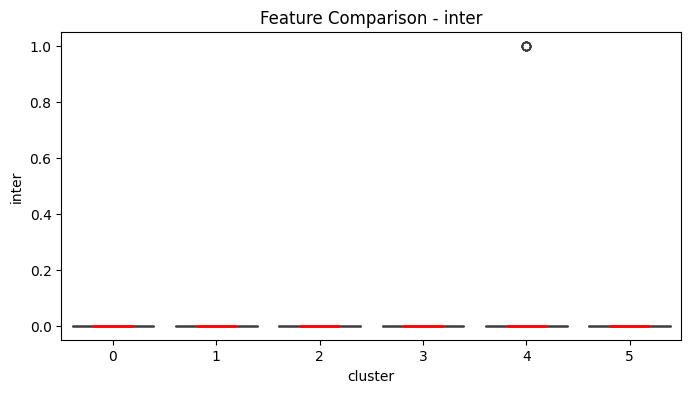

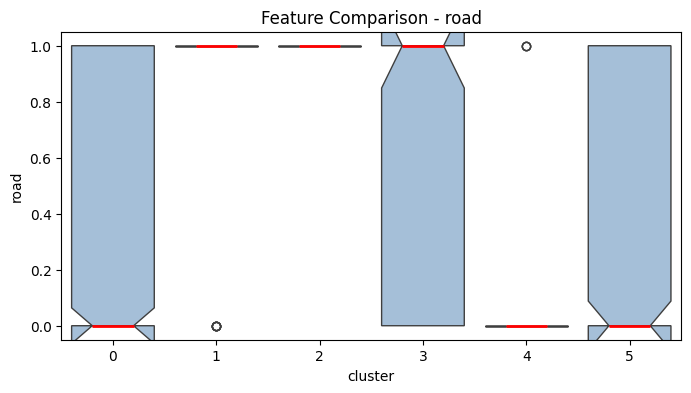

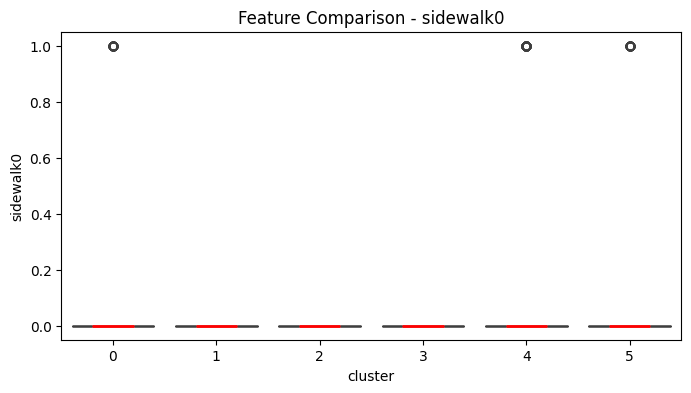

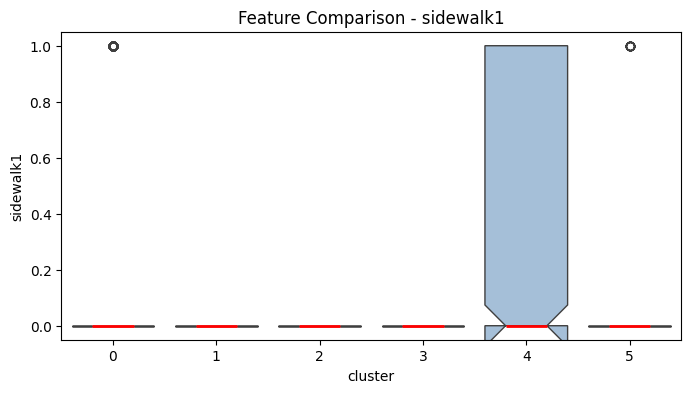

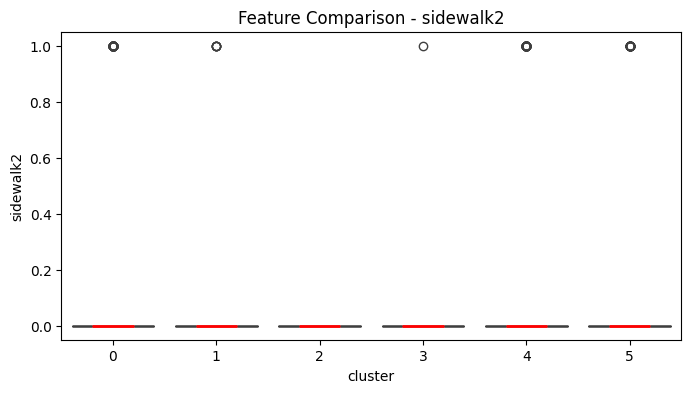

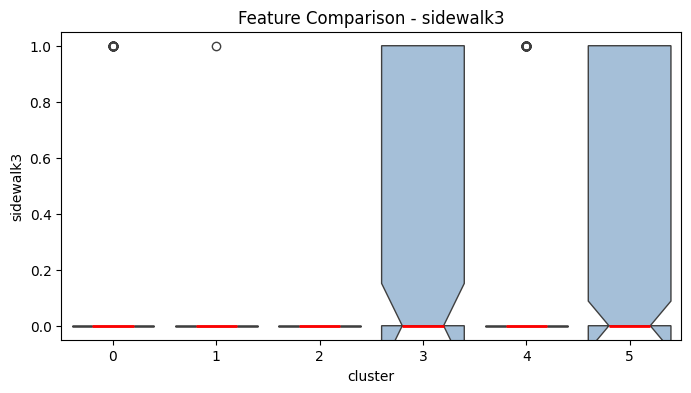

In [374]:
import seaborn as sns

for column in df.columns[:-1]:  # Exclude the cluster label
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='cluster', y=column, data=df, 
                # color=".8", linecolor="#137", linewidth=.75
                notch=True, showcaps=False,
                boxprops={"facecolor": (.3, .5, .7, .5)},
                medianprops={"color": "r", "linewidth": 2},)
    plt.title(f"Feature Comparison - {column}")
    plt.show()

In [353]:
from sklearn.metrics import silhouette_score

score = silhouette_score(df.iloc[:, :-1], df['cluster'])
print("Silhouette Score: ", score)

Silhouette Score:  0.46236646625422334


##### PCA After Clustering

In [338]:
pca = PCA(n_components=3)  # Reducing to 3 dimensions as an example
principal_components = pca.fit_transform(df)

df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
df_pca['cluster'] = df['cluster']  # Add cluster labels to this new DataFrame

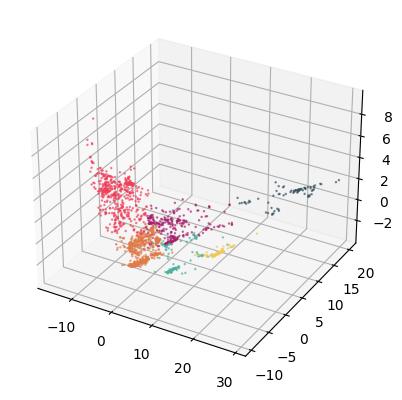

In [339]:
# Creating a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extracting the cluster names and colors
clusters = df_pca['cluster'].unique()
# colors = sns.color_palette('viridis', len(clusters))

for cluster, color in zip(clusters, COLOR_PALETE):
    cluster_data = df_pca[df_pca['cluster'] == cluster]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'], s=.6, alpha=0.6, label=f'Cluster {cluster}', color=color)


/tmp/ipykernel_13580/314783074.py:4: UserWarning: The palette list has more values (9) than needed (6), which may not be intended.
  sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette=COLOR_PALETE, s=20)


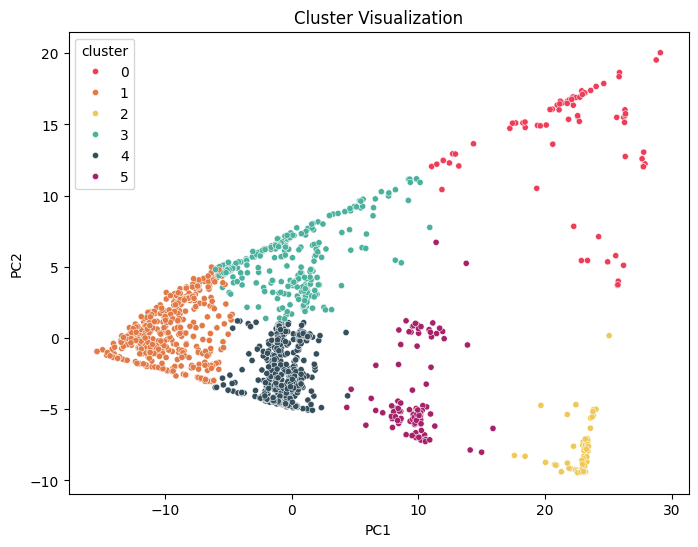

In [340]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette=COLOR_PALETE, s=20)
plt.title('Cluster Visualization')
plt.show()

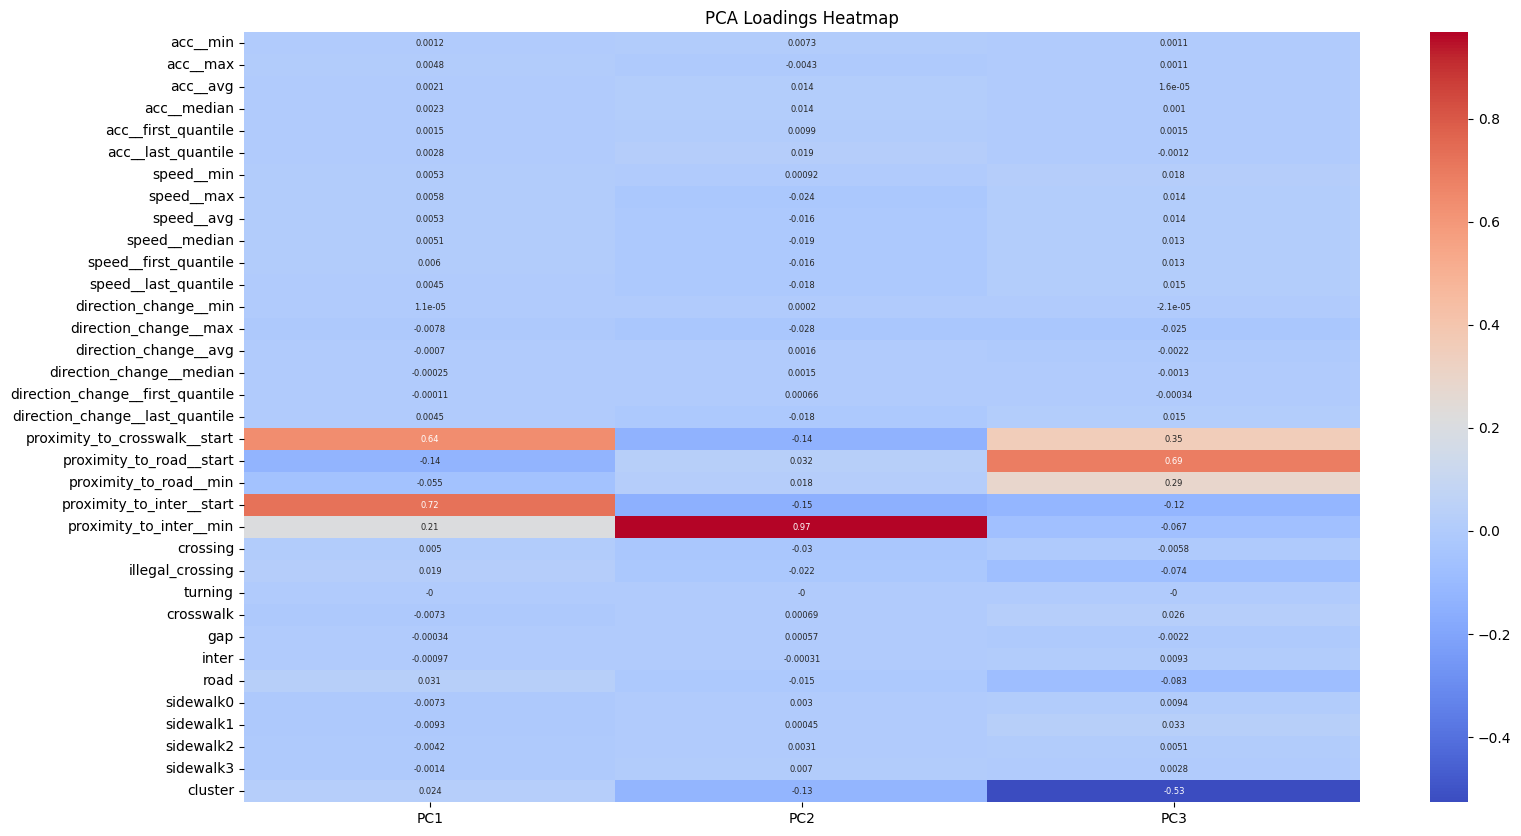

In [341]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'pca' is your fitted PCA object and 'df' is your original DataFrame

# Get loadings
loadings = pca.components_

# Create a heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(loadings.T, annot=True, cmap='coolwarm', 
            yticklabels=df.columns, xticklabels=[f'PC{i+1}' for i in range(len(loadings))], annot_kws={"size":6})
plt.title('PCA Loadings Heatmap')
plt.show()


/tmp/ipykernel_13580/2887147349.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.columns, rotation=90, ha='right')


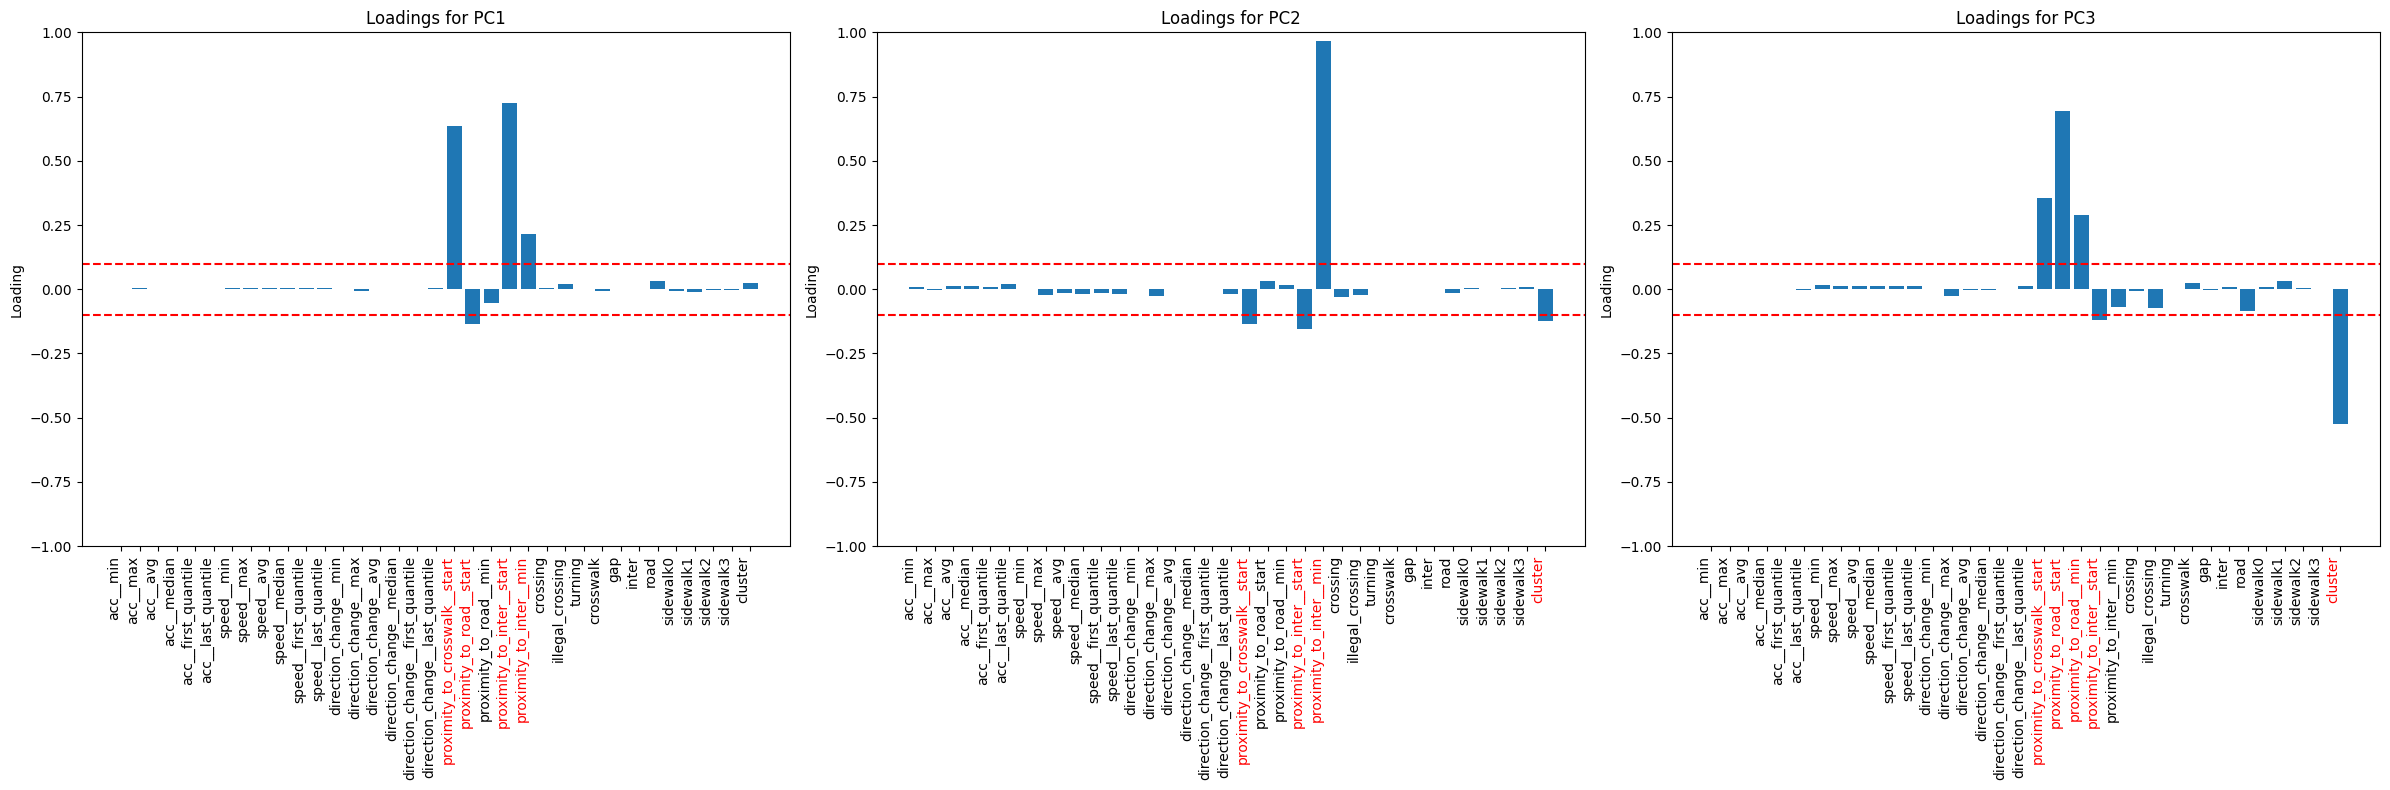

In [342]:
# Set the threshold for highlighting
threshold = 0.1

# Number of principal components
num_pcs = 3

plt.figure(figsize=(8*num_pcs, 8))

# Iterate through the first three PCs
for i in range(num_pcs):
    ax = plt.subplot(1, num_pcs, i+1)
    bars = ax.bar(df.columns, loadings[i, :])
    
    # Color feature names red if the bar is above 0.2
    for bar, label in zip(bars, ax.get_xticklabels()):
        label.set_color('red' if abs(bar.get_height()) > threshold else 'black')

     # Add a red horizontal line at the threshold
    ax.axhline(y=threshold, color='red', linestyle='--')
    ax.axhline(y=-threshold, color='red', linestyle='--')  # For negative values

    ax.set_xticklabels(df.columns, rotation=90, ha='right')
    ax.set_ylim((-1, 1))
    plt.ylabel('Loading')
    plt.title(f'Loadings for PC{i+1}')

plt.tight_layout()
plt.show()

/tmp/ipykernel_13580/3405095845.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(df.columns, ha='right')


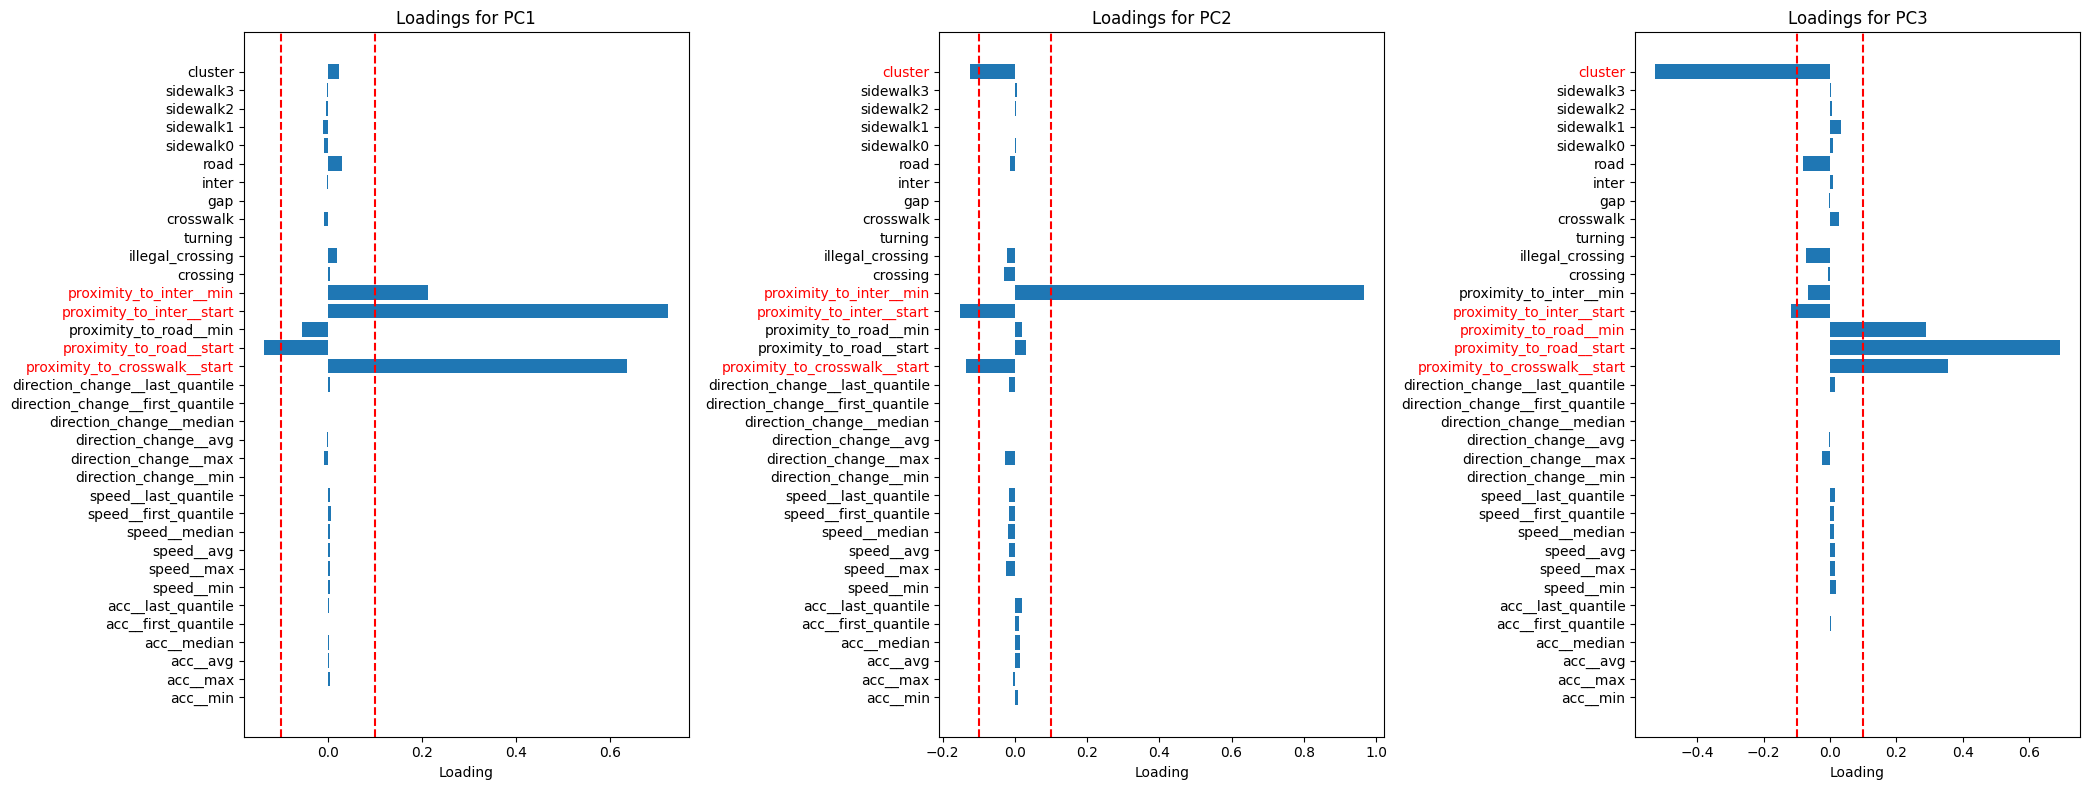

In [343]:
# Set the threshold for highlighting
threshold = 0.1

# Number of principal components
num_pcs = 3

plt.figure(figsize=(num_pcs*7, 8))

# Iterate through the first three PCs
for i in range(num_pcs):
    ax = plt.subplot(1, num_pcs, i+1)
    bars = ax.barh(df.columns, loadings[i, :])
    
    # Color feature names red if the bar is above 0.2
    # Color feature names red if the bar is above 0.2 and adjust x-tick labels
    for bar, label in zip(bars, ax.get_yticklabels()):
        label.set_color('red' if abs(bar.get_width()) > threshold else 'black')


     # Add a red horizontal line at the threshold
    ax.axvline(x=threshold, color='red', linestyle='--')
    ax.axvline(x=-threshold, color='red', linestyle='--')  # For negative values
    
    ax.set_yticklabels(df.columns, ha='right')

    plt.xlabel('Loading')
    plt.title(f'Loadings for PC{i+1}')

plt.tight_layout()
plt.show()